In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

In [89]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

In [90]:
sales = pd.read_csv('sales.csv')
stores = pd.read_csv('stores.csv')
features = pd.read_csv('features.csv')

In [91]:
sales.dropna(subset=['Weekly_Sales'])
sales.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [92]:
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [93]:
features.drop(['IsHoliday'], axis=1, inplace=True)
features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106


In [94]:
after_join = pd.merge(sales, stores, how='left', on=['Store'])
after_join = pd.merge(after_join, features, how='left', on=['Store', 'Date'])
after_join.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
1,1,1,2010-02-12,46039.49,True,A,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106
2,1,1,2010-02-19,41595.55,False,A,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106
3,1,1,2010-02-26,19403.54,False,A,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106
4,1,1,2010-03-05,21827.90,False,A,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106


NaNlist = [MarkDown1, MarkDown2, MarkDown3, MarkDown4, MarkDown5]

In [95]:
after_join['Unemployment'].isnull().values.any() #This can be used to check if there is any NaN values in a column

False

In [96]:
one_hot_encoder = OneHotEncoder(handle_unknown='ignore') #Handling Type
encoder_df = pd.DataFrame(one_hot_encoder.fit_transform(after_join[['Type']]).toarray())
encoder_df.columns = one_hot_encoder.get_feature_names_out(['Type'])
after_encode = after_join.join(encoder_df)
after_encode.drop(['Type'], axis=1, inplace=True)
after_encode.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type_A,Type_B,Type_C
0,1,1,2010-02-05,24924.50,False,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,1.0,0.0,0.0
1,1,1,2010-02-12,46039.49,True,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,1.0,0.0,0.0
2,1,1,2010-02-19,41595.55,False,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,1.0,0.0,0.0
3,1,1,2010-02-26,19403.54,False,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,1.0,0.0,0.0
4,1,1,2010-03-05,21827.90,False,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,1.0,0.0,0.0


In [97]:
after_encode['Date'] = pd.to_datetime(after_encode['Date'])

In [98]:
after_encode['Year'] = after_encode['Date'].dt.year
after_encode['Month'] = after_encode['Date'].dt.month
after_encode['MonthSin'] = np.sin(2 * np.pi * after_encode['Month']/12)
after_encode['MonthCos'] = np.cos(2 * np.pi * after_encode['Month']/12)
after_encode['Day'] = after_encode['Date'].dt.day
after_encode['DaySin'] = np.sin(2 * np.pi * after_encode['Day']/31)
after_encode['DayCos'] = np.cos(2 * np.pi * after_encode['Day']/31)
after_encode['Week'] = after_encode['Date'].dt.isocalendar().week
after_encode['Quarter'] = after_encode['Date'].dt.quarter
after_encode['Semester'] = np.where(after_encode['Quarter'].isin([1, 2]), 1, 2)
after_encode['IsMonthStart'] = after_encode['Date'].dt.is_month_start
after_encode['IsMonthEnd'] = after_encode['Date'].dt.is_month_end
#All dates are friday
#after_encode['DayOfWeek'] = after_encode['Date'].dt.dayofweek
#after_encode['IsWeekend'] = np.where(after_encode['DayOfWeek'].isin([5, 6]), 1, 0)

In [99]:
label_encoder1 = LabelEncoder() #Handling Binary Values
after_encode['IsHoliday'] = label_encoder1.fit_transform(after_encode['IsHoliday'])
label_encoder2 = LabelEncoder()
after_encode['IsMonthStart'] = label_encoder2.fit_transform(after_encode['IsMonthStart'])
label_encoder3 = LabelEncoder()
after_encode['IsMonthEnd'] = label_encoder3.fit_transform(after_encode['IsMonthEnd'])

In [100]:
after_encode.drop(['Date'], axis=1, inplace=True)

In [101]:
after_encode.head()

,Store,Dept,Weekly_Sales,IsHoliday,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,...,MonthSin,MonthCos,Day,DaySin,DayCos,Week,Quarter,Semester,IsMonthStart,IsMonthEnd
0,1,1,24924.50,0,151315,42.31,2.572,NaN,NaN,NaN,...,0.866025,5.000000e-01,5,0.848644,0.528964,5,1,1,0,0
1,1,1,46039.49,1,151315,38.51,2.548,NaN,NaN,NaN,...,0.866025,5.000000e-01,12,0.651372,-0.758758,6,1,1,0,0
2,1,1,41595.55,0,151315,39.93,2.514,NaN,NaN,NaN,...,0.866025,5.000000e-01,19,-0.651372,-0.758758,7,1,1,0,0
3,1,1,19403.54,0,151315,46.63,2.561,NaN,NaN,NaN,...,0.866025,5.000000e-01,26,-0.848644,0.528964,8,1,1,0,0
4,1,1,21827.90,0,151315,46.50,2.625,NaN,NaN,NaN,...,1.000000,6.123234e-17,5,0.848644,0.528964,9,1,1,0,0


In [102]:
y = after_encode['Weekly_Sales'] # Determining y, target variable
y.head()

0    24924.50
1    46039.49
2    41595.55
3    19403.54
4    21827.90
Name: Weekly_Sales, dtype: float64

In [103]:
after_encode.drop(['Weekly_Sales'], axis=1, inplace=True)

In [104]:
X = after_encode # Determining X, input variables
X.head()

,Store,Dept,IsHoliday,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,...,MonthSin,MonthCos,Day,DaySin,DayCos,Week,Quarter,Semester,IsMonthStart,IsMonthEnd
0,1,1,0,151315,42.31,2.572,NaN,NaN,NaN,NaN,...,0.866025,5.000000e-01,5,0.848644,0.528964,5,1,1,0,0
1,1,1,1,151315,38.51,2.548,NaN,NaN,NaN,NaN,...,0.866025,5.000000e-01,12,0.651372,-0.758758,6,1,1,0,0
2,1,1,0,151315,39.93,2.514,NaN,NaN,NaN,NaN,...,0.866025,5.000000e-01,19,-0.651372,-0.758758,7,1,1,0,0
3,1,1,0,151315,46.63,2.561,NaN,NaN,NaN,NaN,...,0.866025,5.000000e-01,26,-0.848644,0.528964,8,1,1,0,0
4,1,1,0,151315,46.50,2.625,NaN,NaN,NaN,NaN,...,1.000000,6.123234e-17,5,0.848644,0.528964,9,1,1,0,0


In [105]:
X_training, X_test, y_training, y_test = train_test_split(X, y) # Splitting data into train and test sets

In [106]:
X_training = X_training.fillna(X_training.mean()) # Filling NaN values with mean
X_test = X_test.fillna(X_training.mean()) # No information is leaked from test to training since we split before filling and filled test values with mean of the training values
X_training.head()

,Store,Dept,IsHoliday,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,...,MonthSin,MonthCos,Day,DaySin,DayCos,Week,Quarter,Semester,IsMonthStart,IsMonthEnd
274958,28,80,0,206302,50.74,3.342,7247.860015,3348.57452,1453.255507,3371.956786,...,0.500000,0.866025,28,-0.571268,0.820763,4,1,1,0,0
213486,22,55,1,119557,46.28,3.536,1649.310000,3348.57452,70087.940000,7.500000,...,-0.500000,0.866025,25,-0.937752,0.347305,47,4,2,0,0
72400,8,27,0,155078,56.86,3.372,7247.860015,3348.57452,1453.255507,3371.956786,...,-0.866025,0.500000,28,-0.571268,0.820763,43,4,2,0,0
213459,22,55,0,119557,58.56,4.101,7247.860015,3348.57452,1453.255507,3371.956786,...,0.500000,-0.866025,20,-0.790776,-0.612106,20,2,1,0,0
351199,37,72,0,39910,69.39,3.622,7247.860015,3348.57452,1453.255507,3371.956786,...,0.866025,-0.500000,8,0.998717,-0.050649,14,2,1,0,0


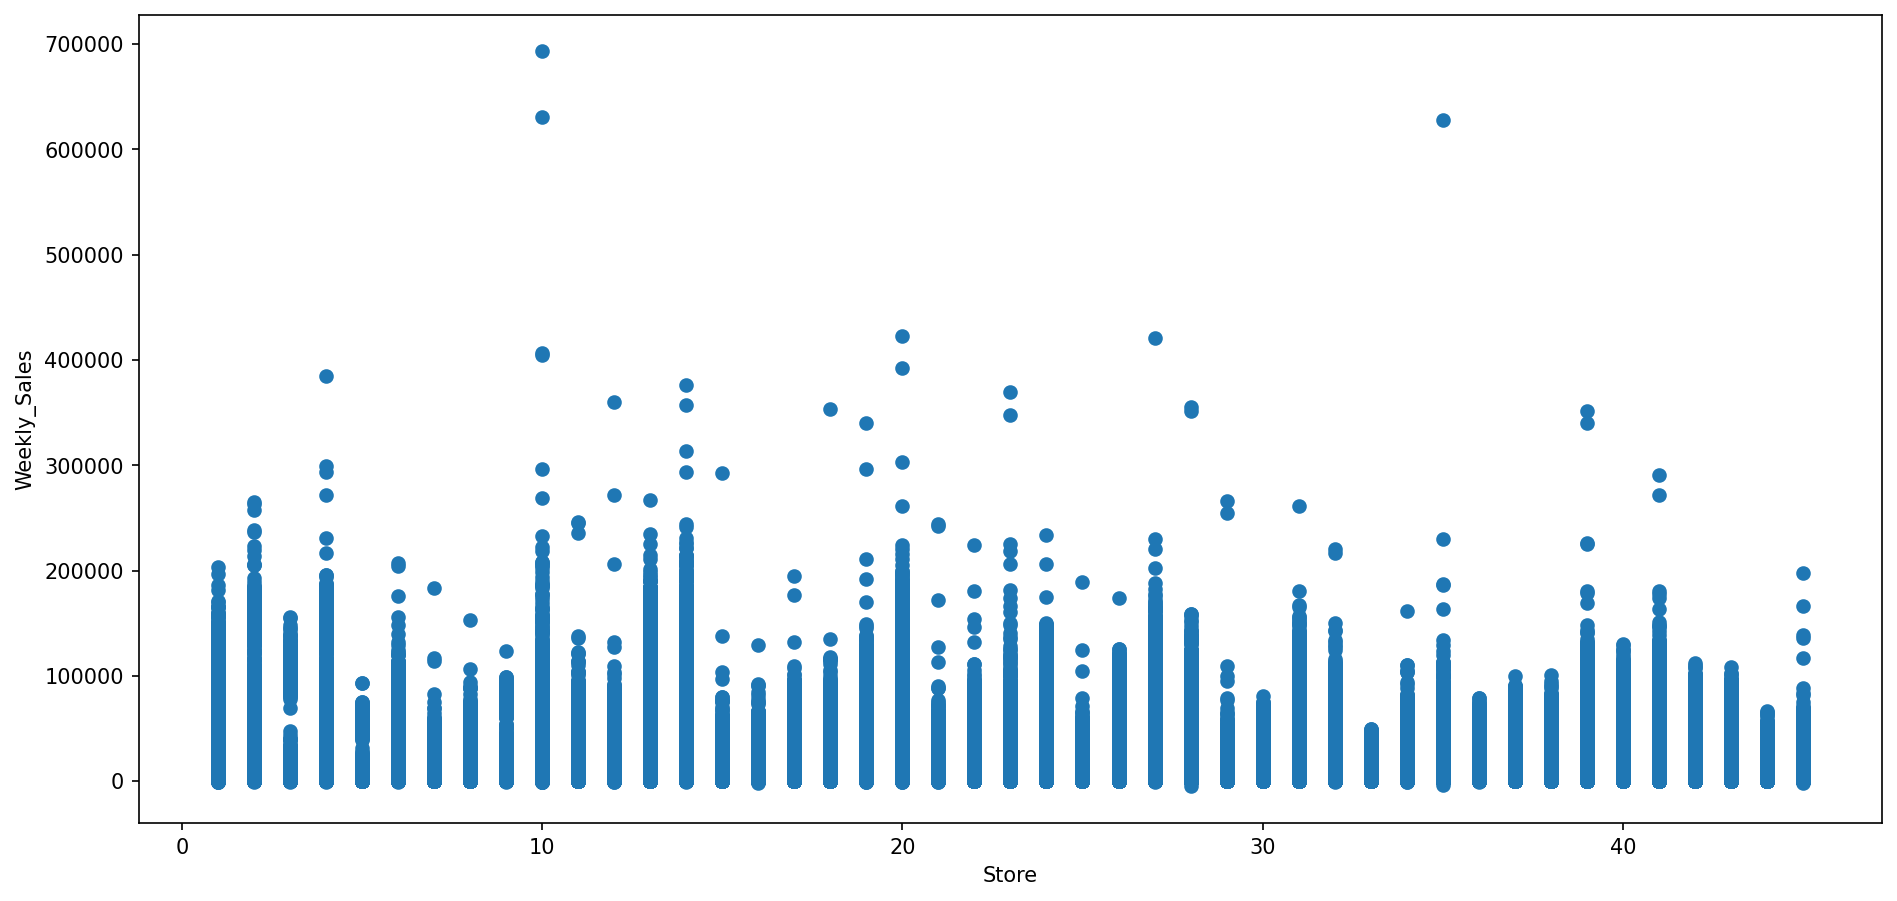

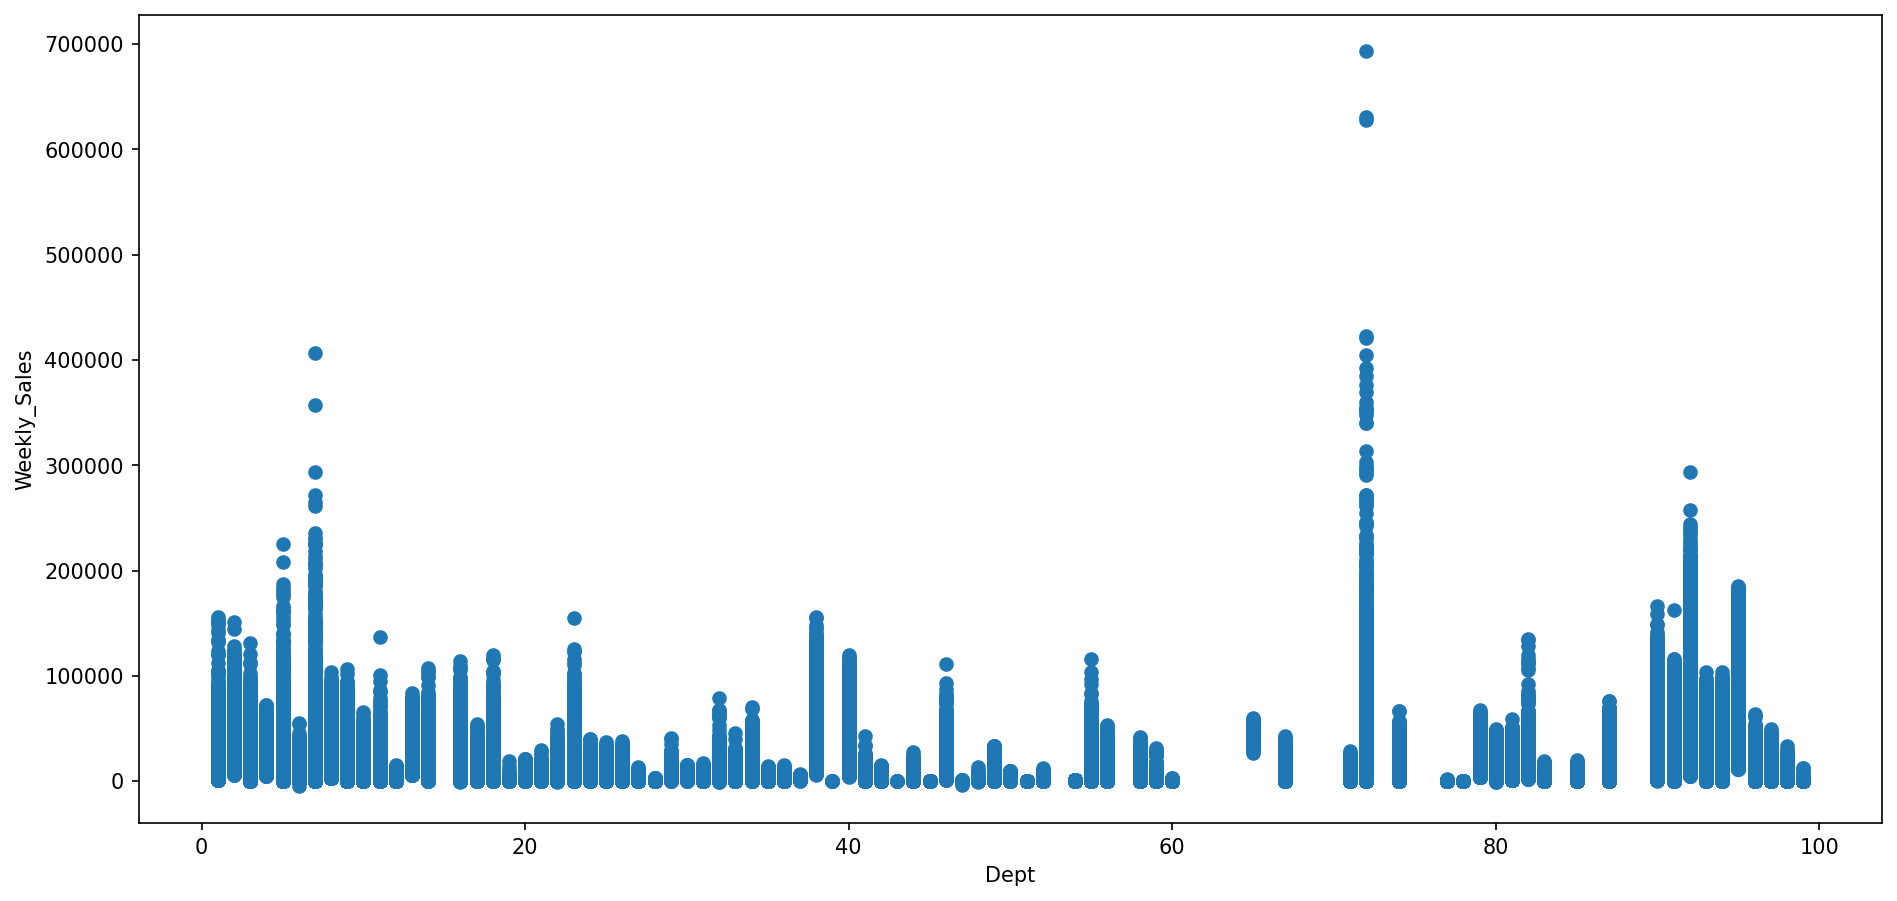

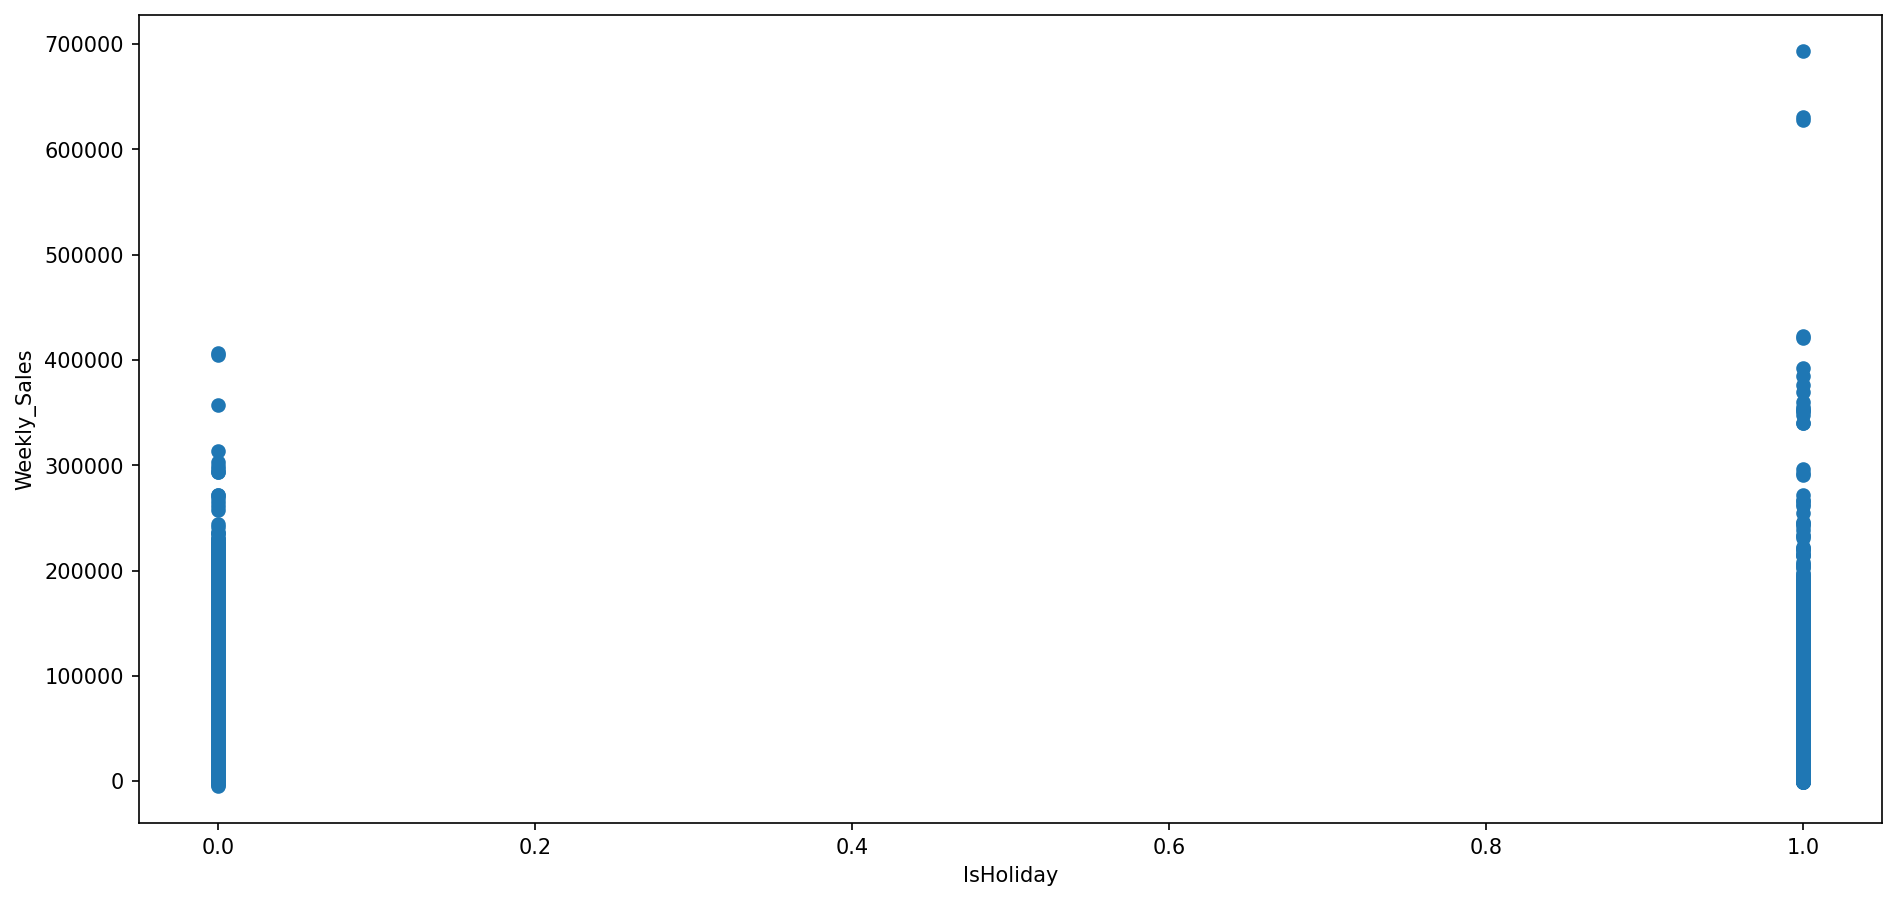

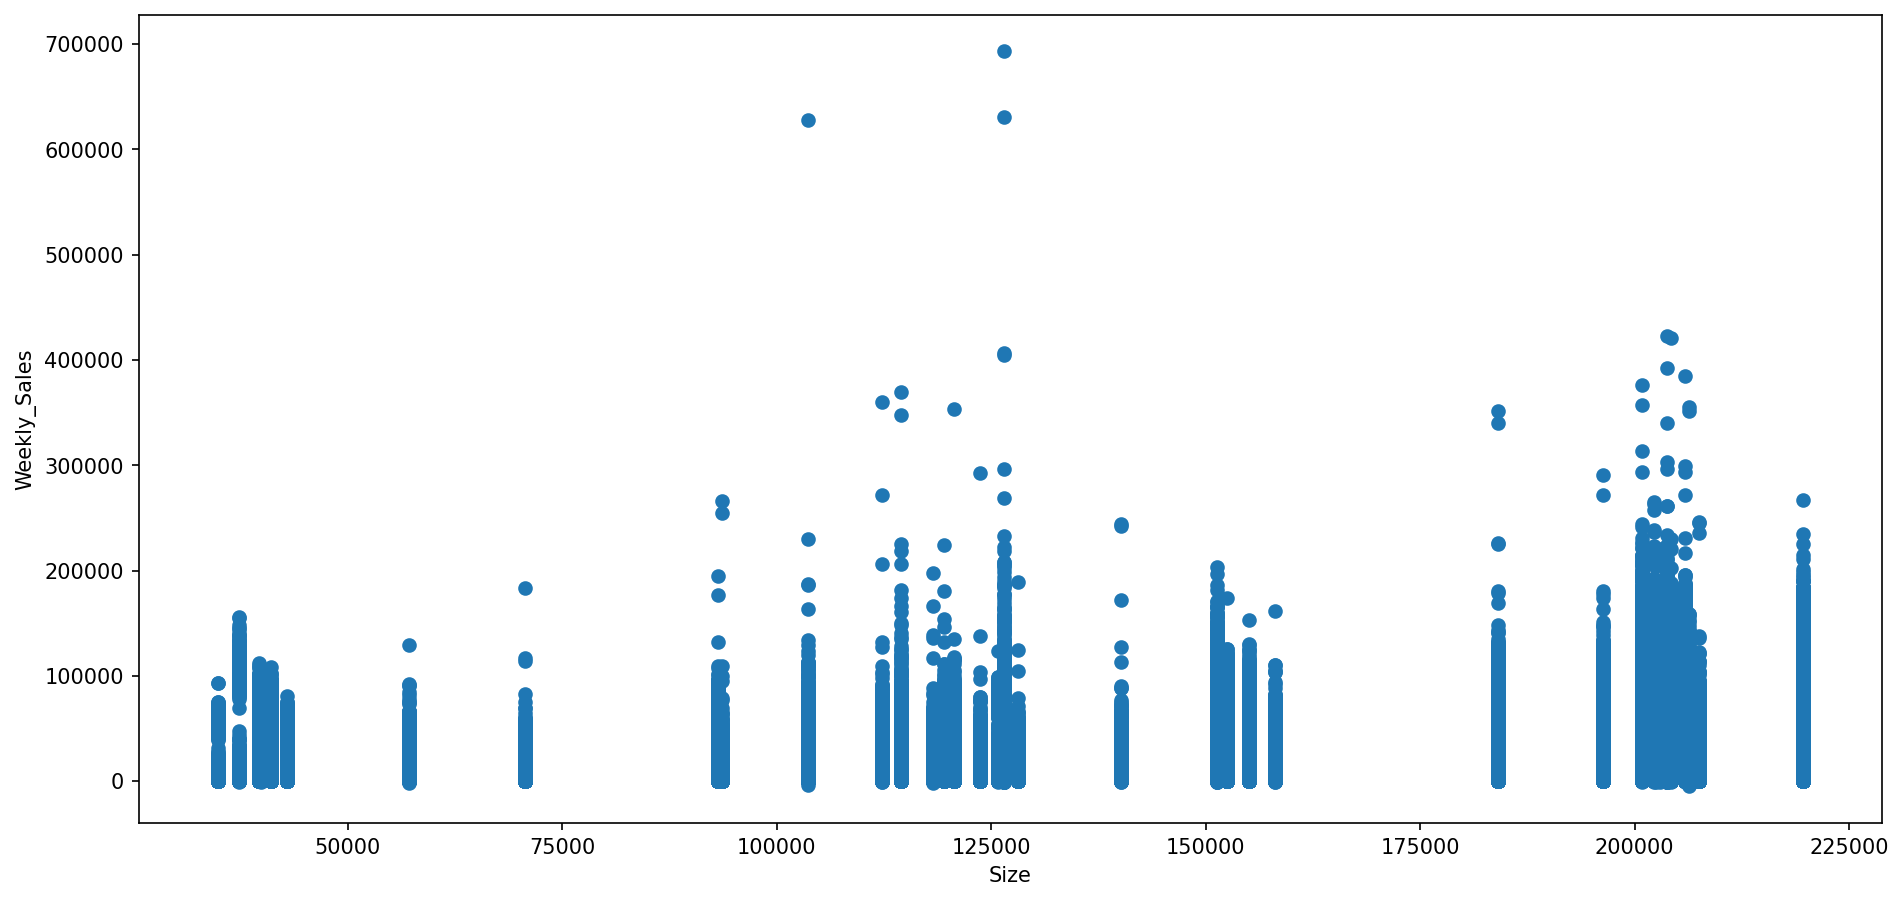

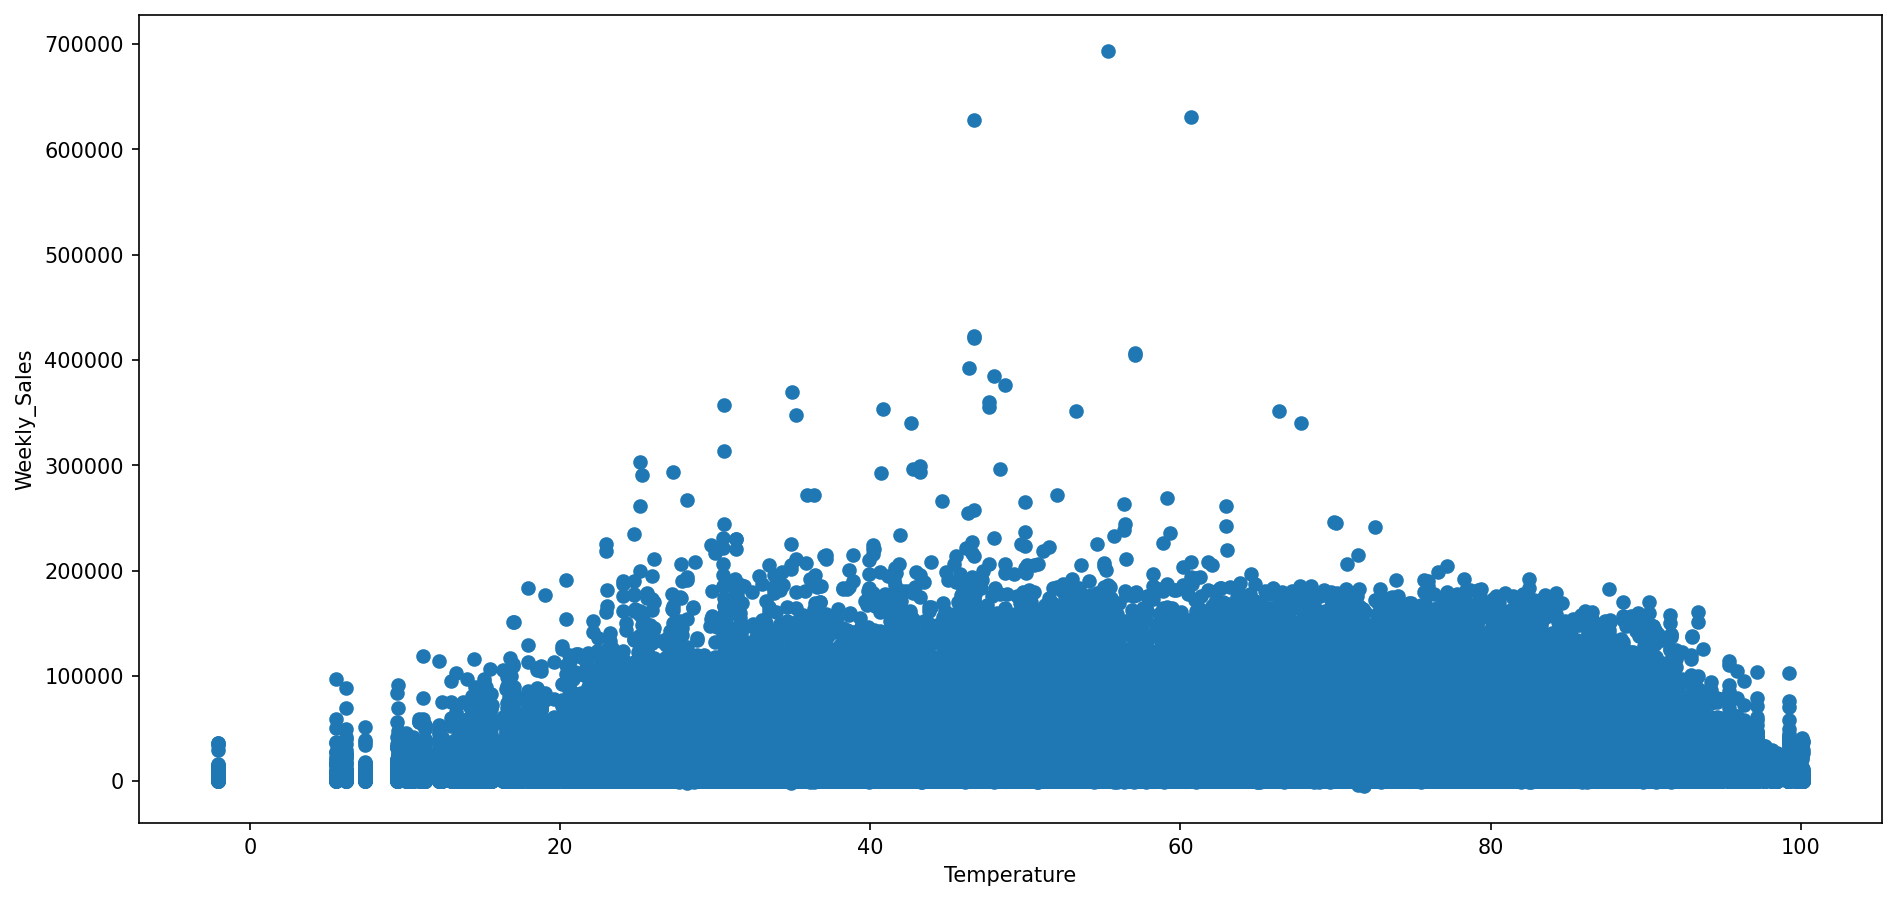

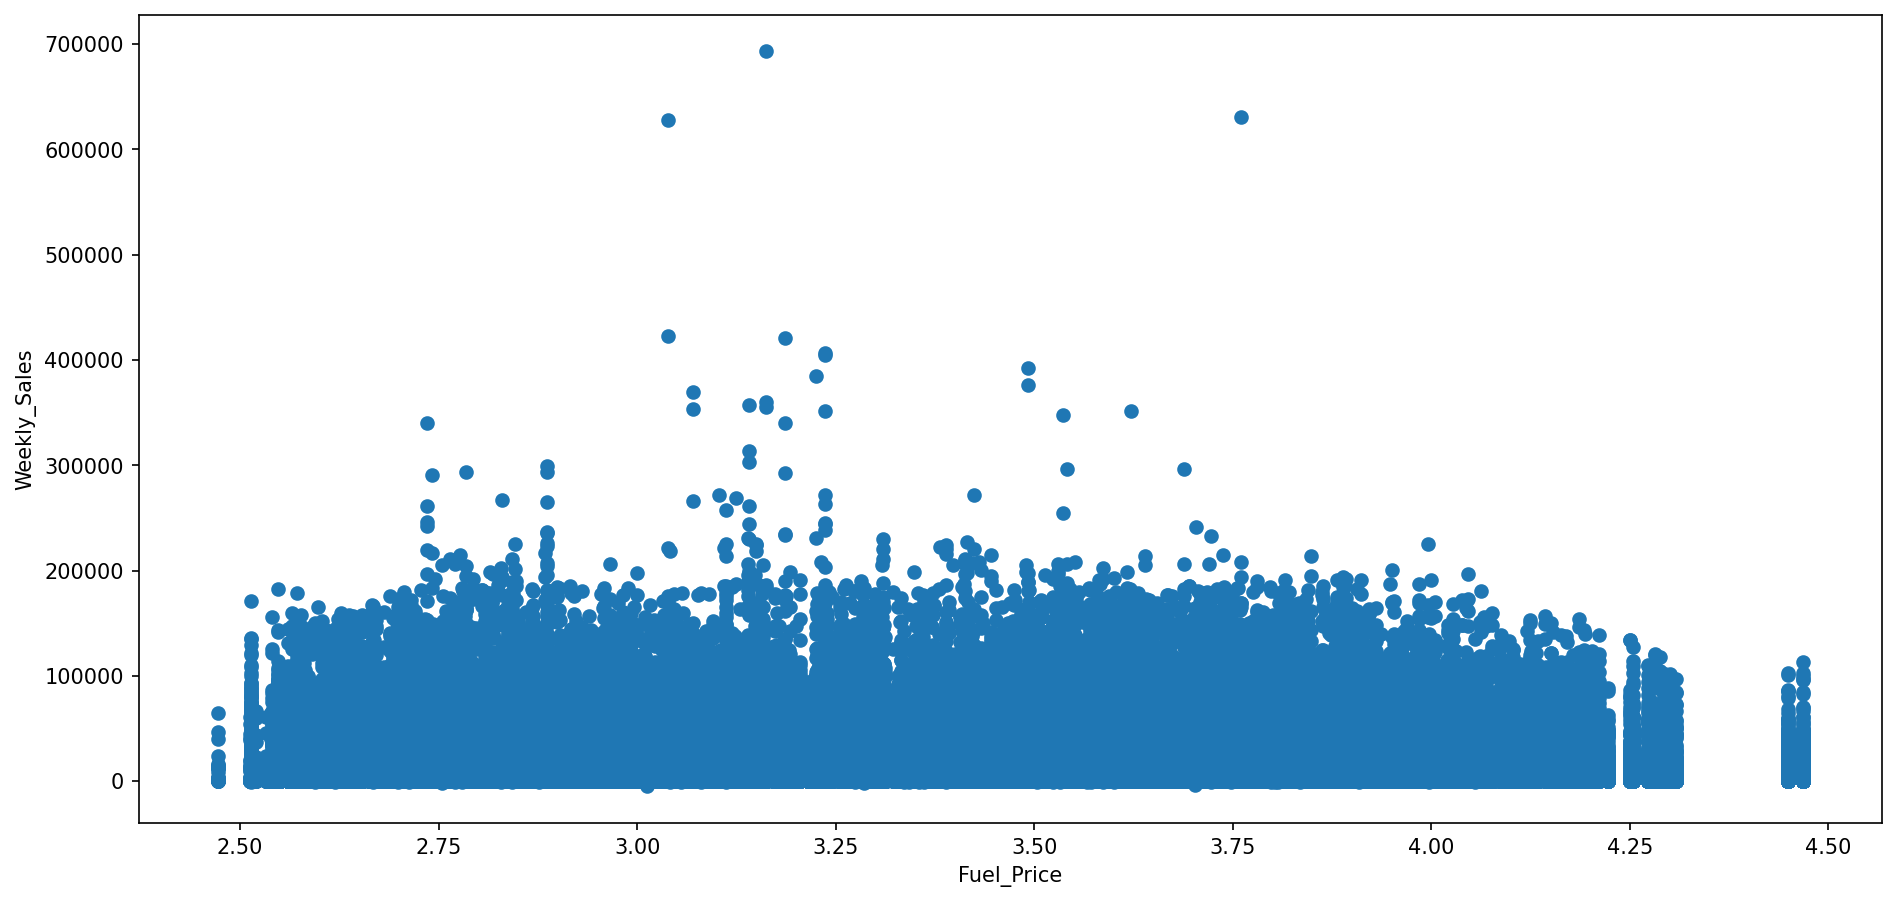

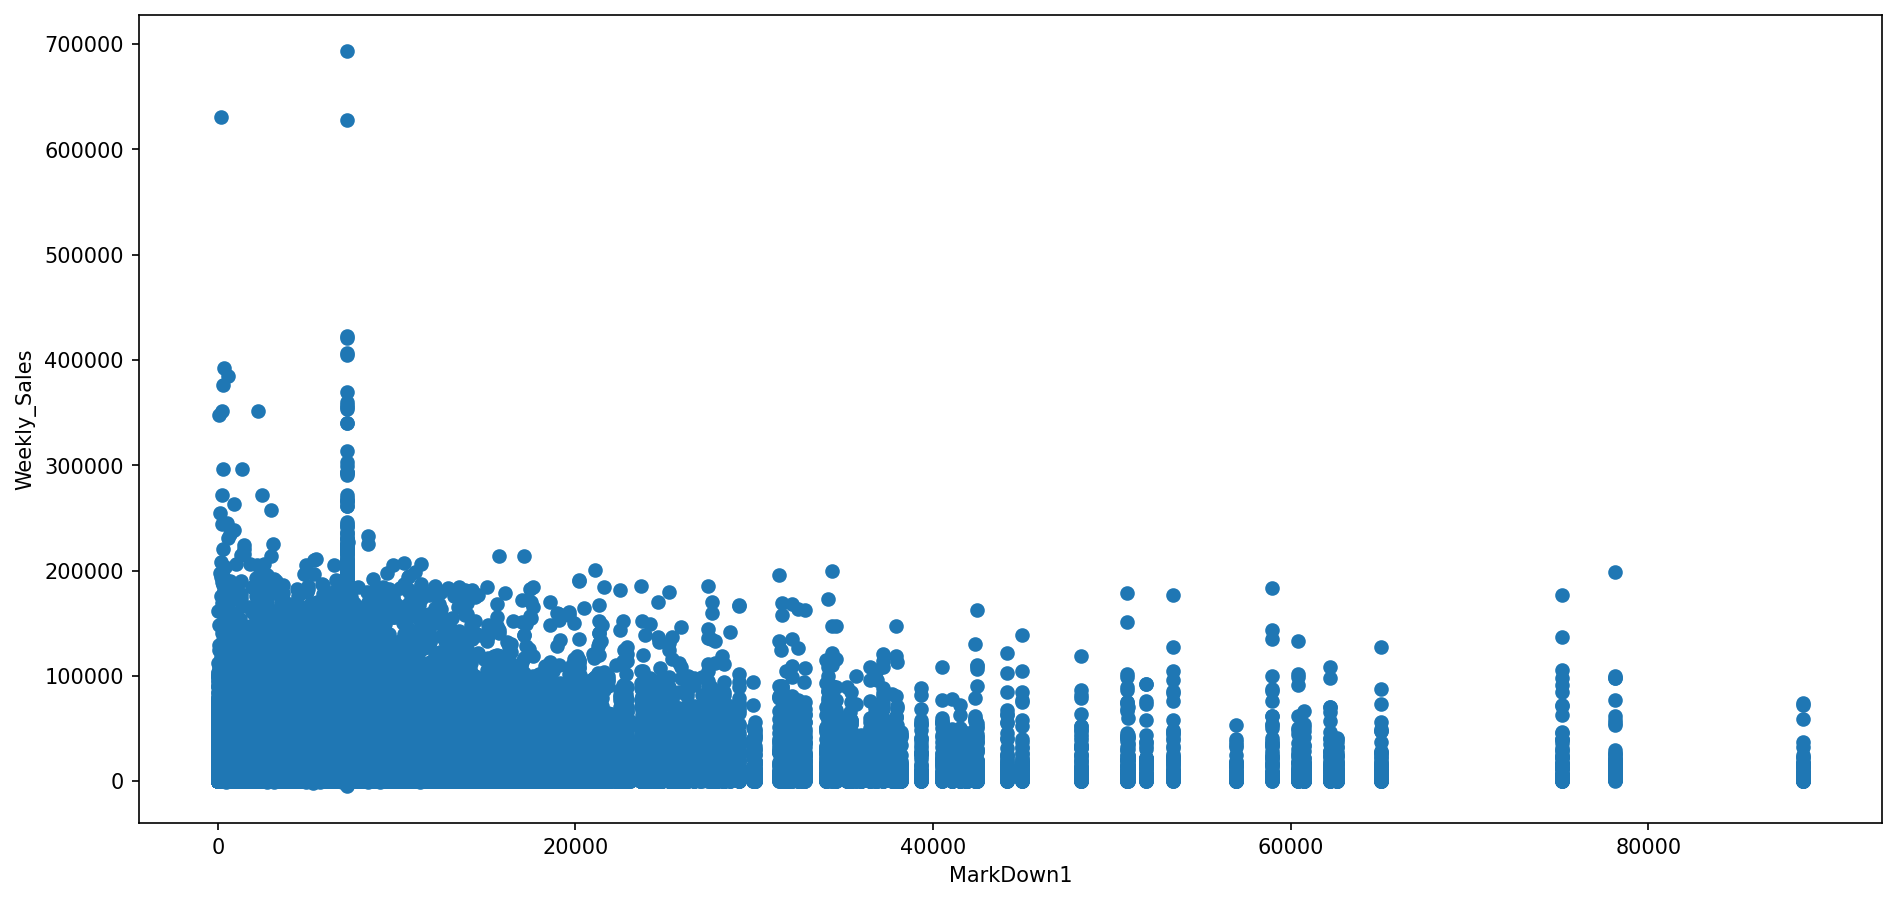

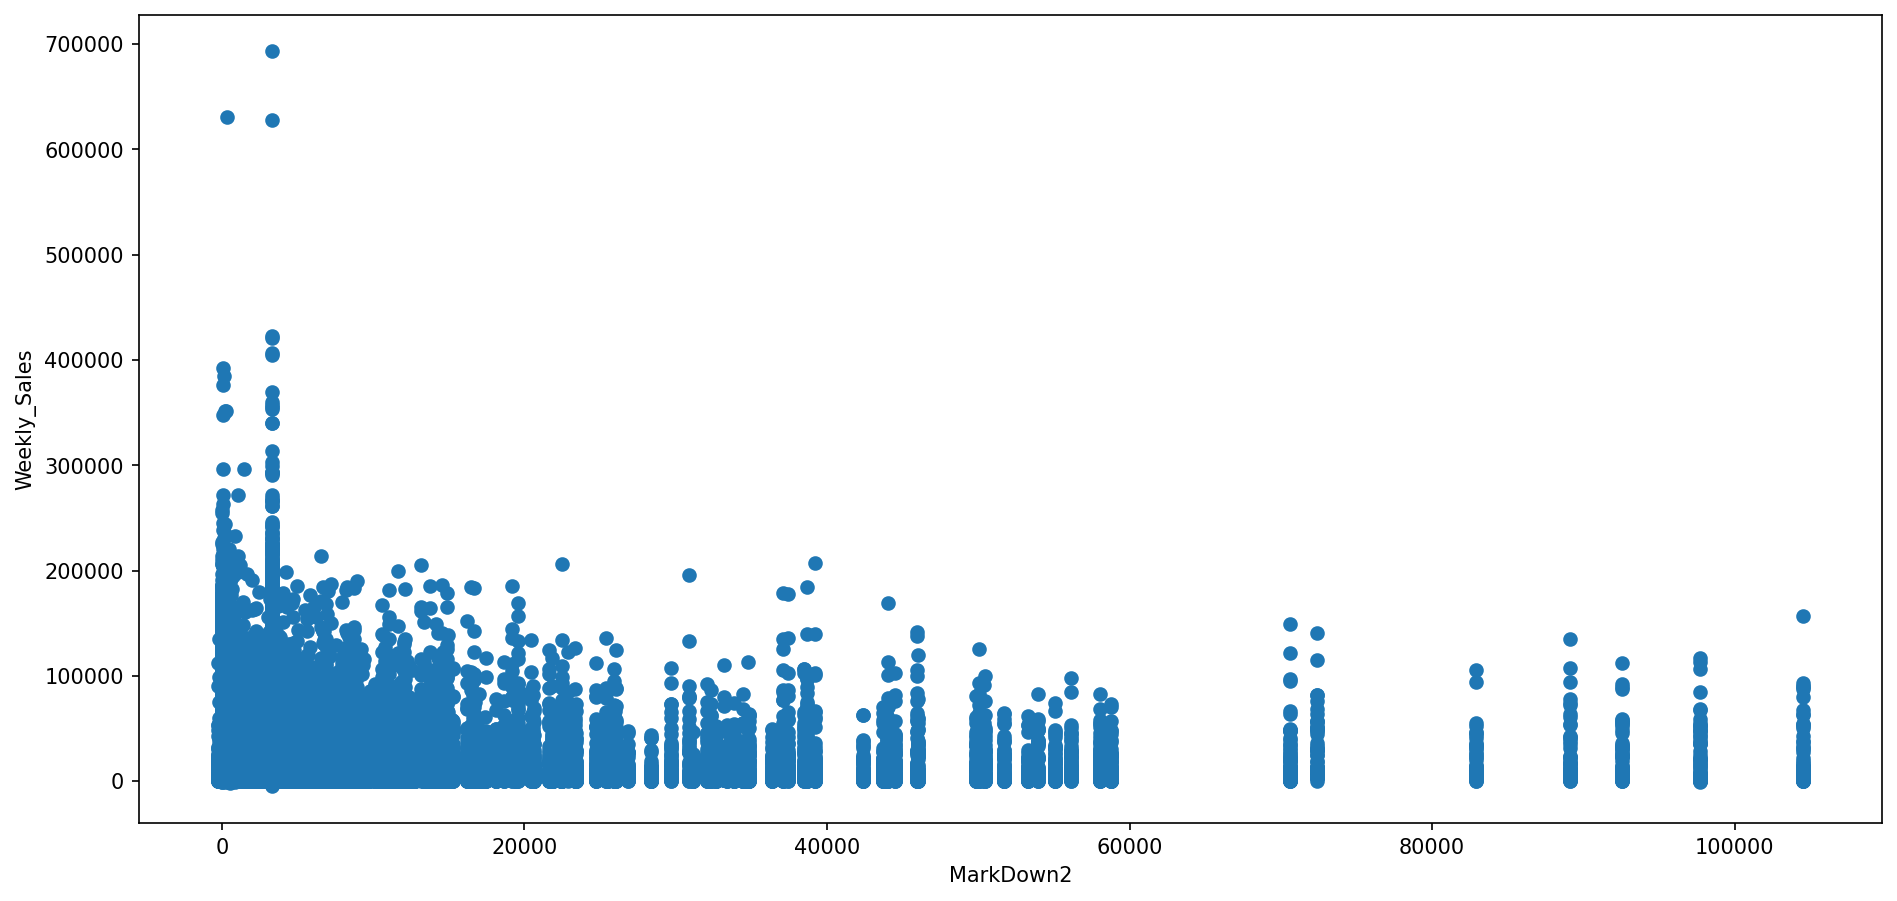

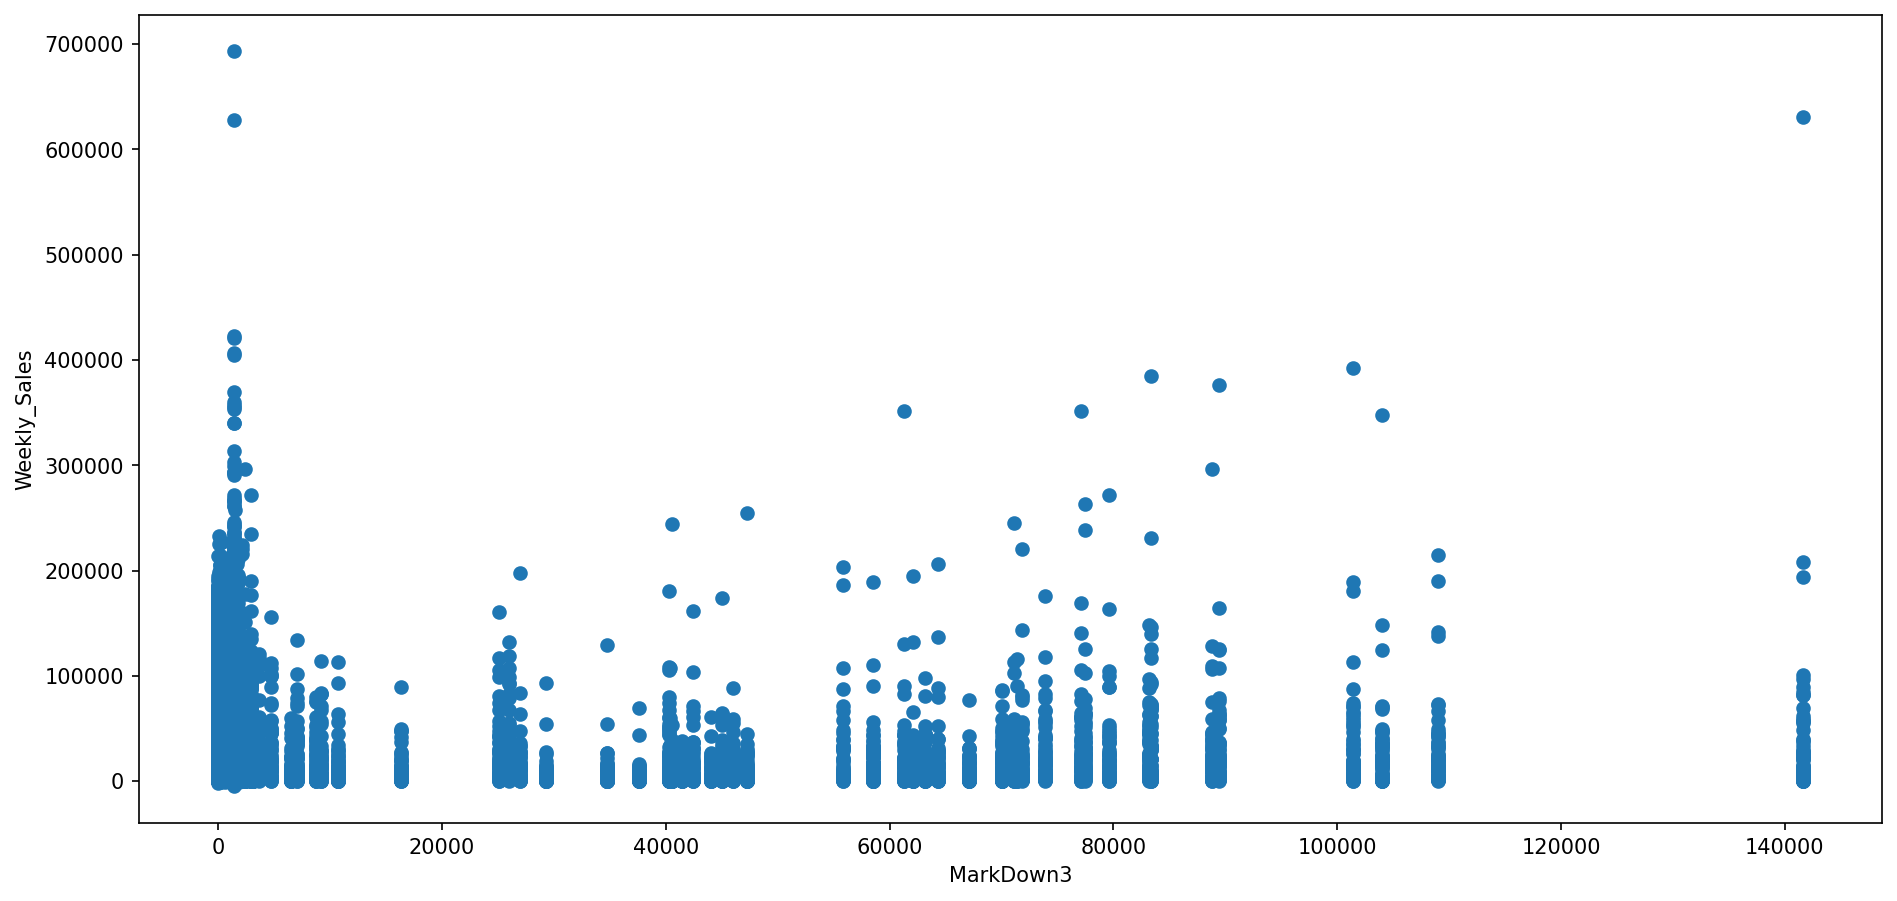

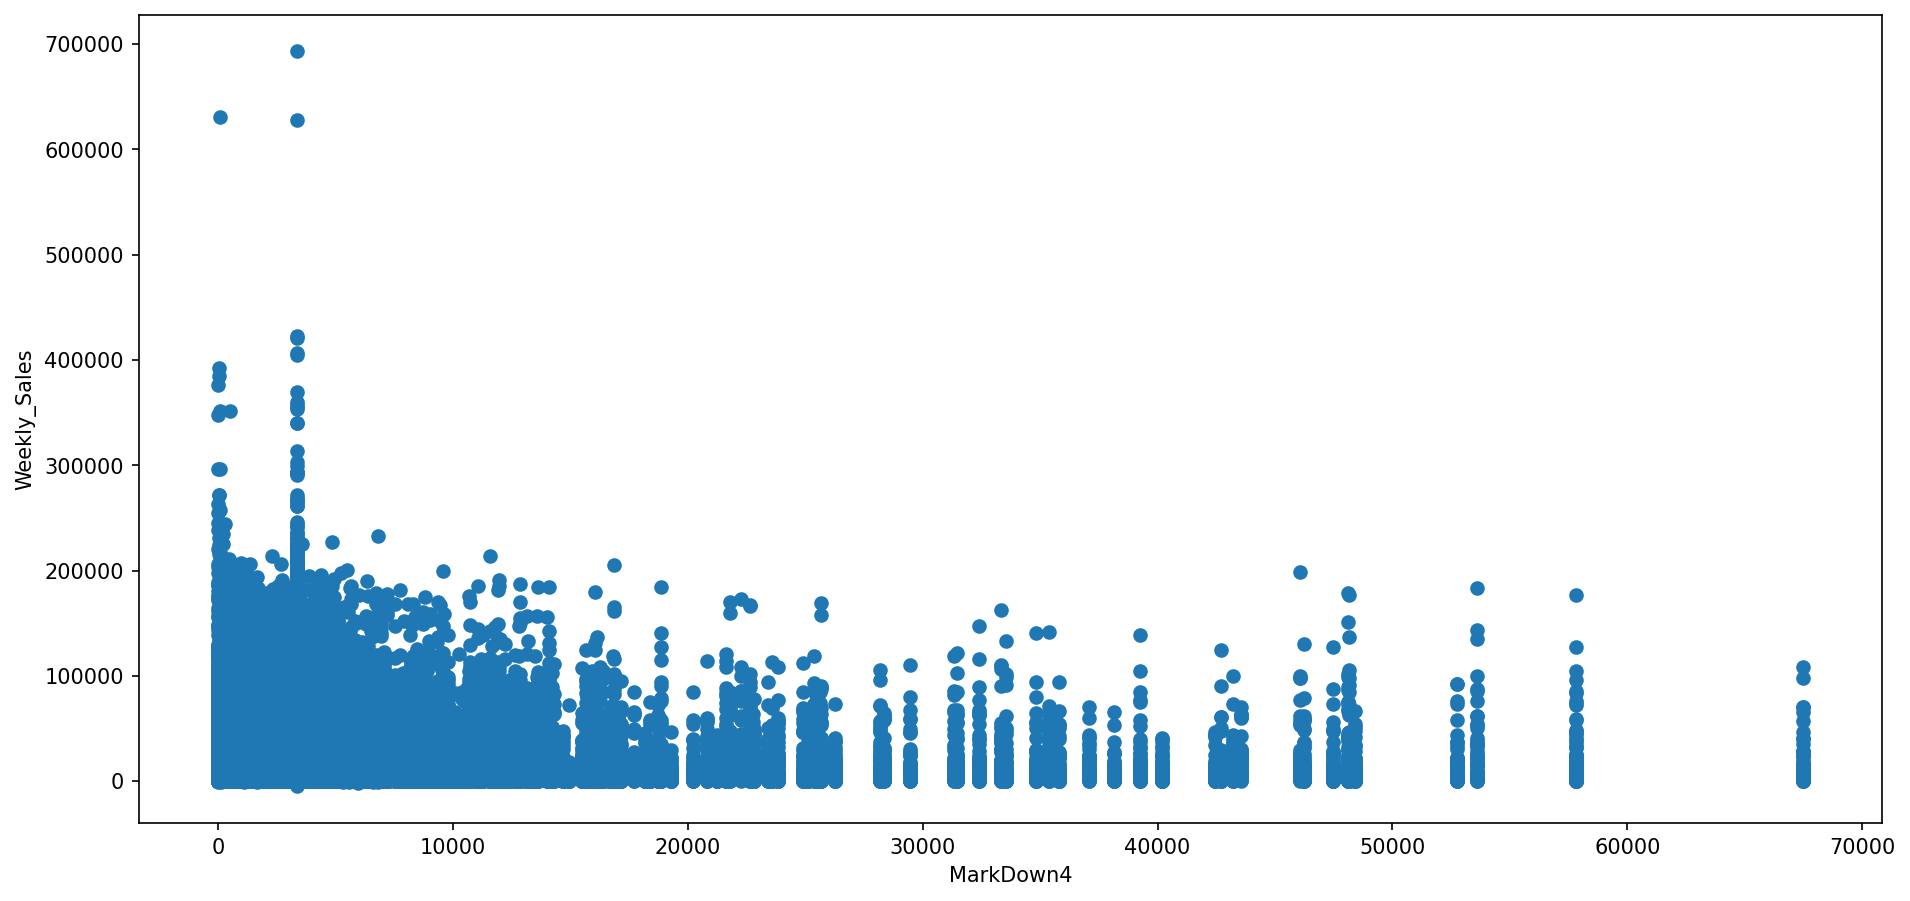

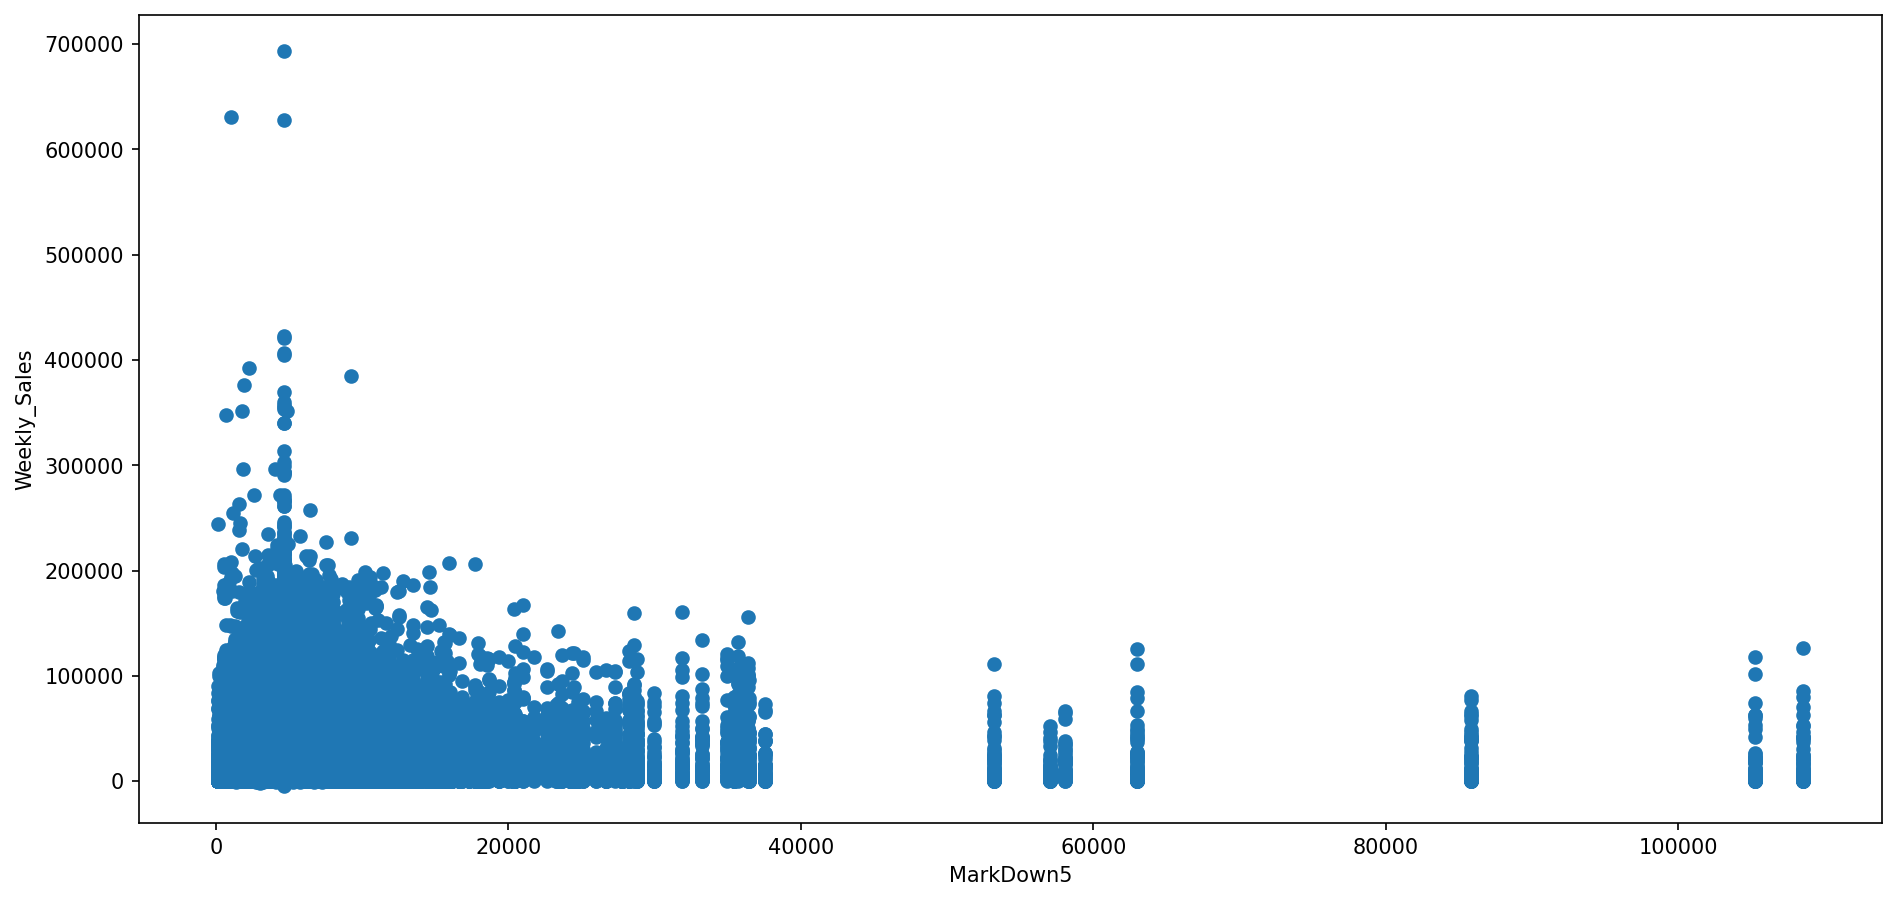

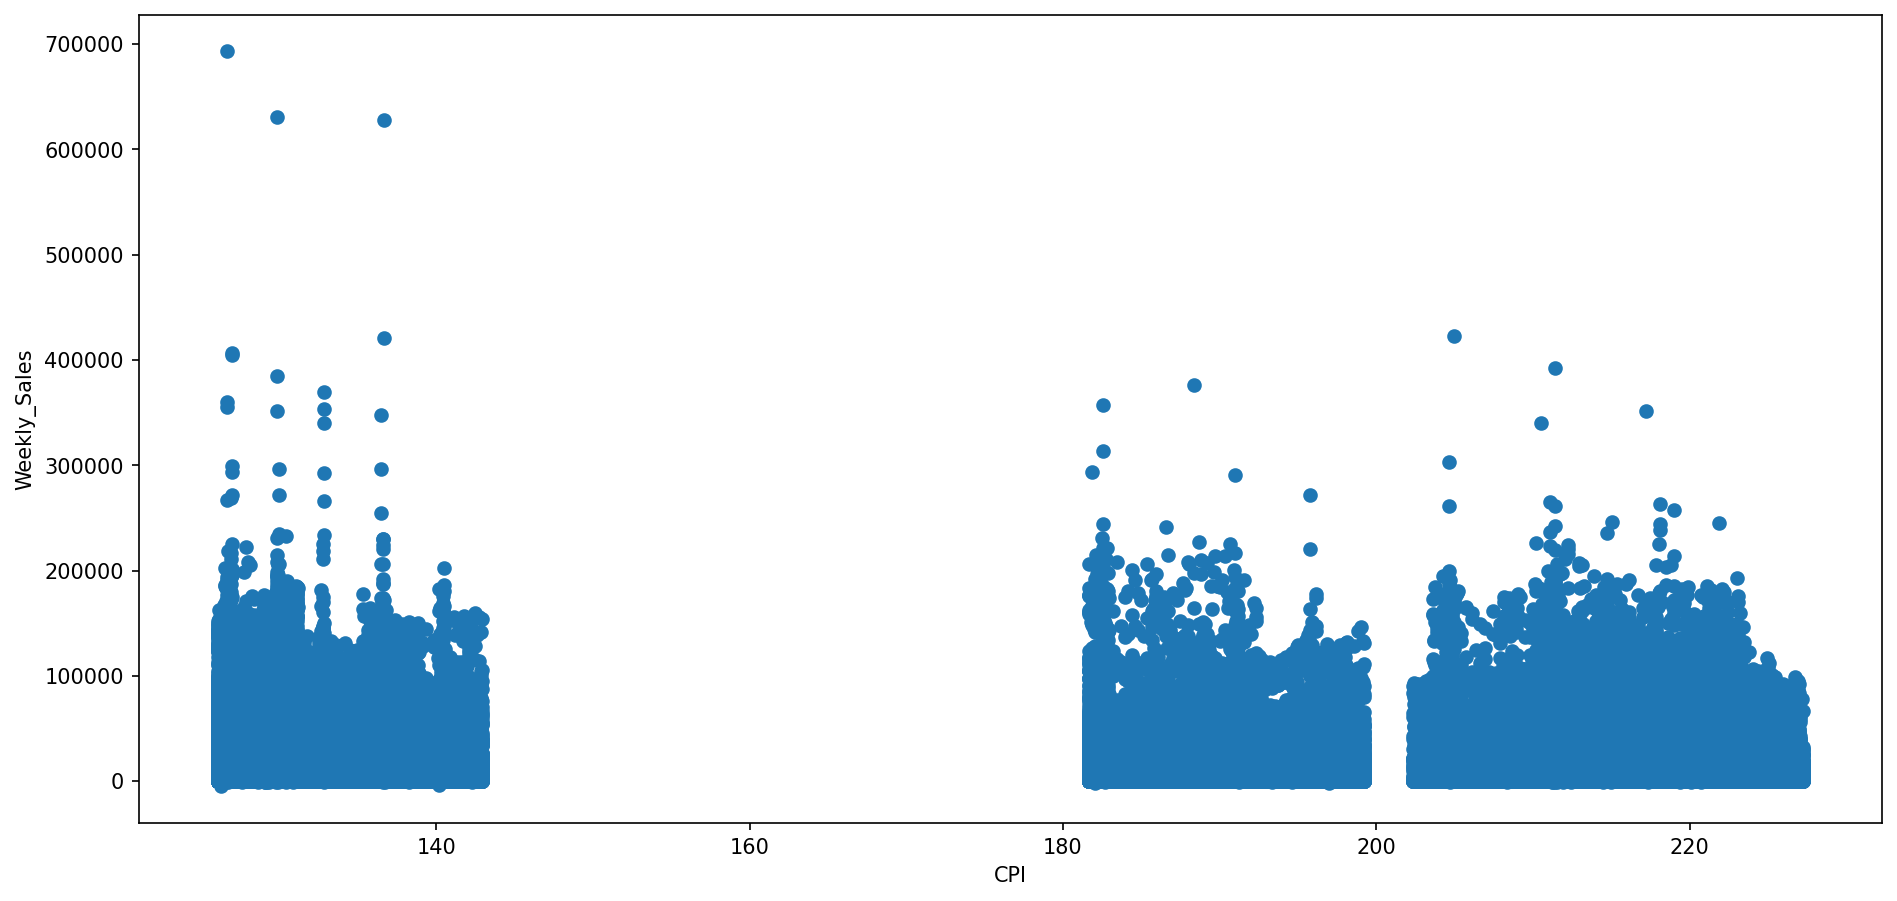

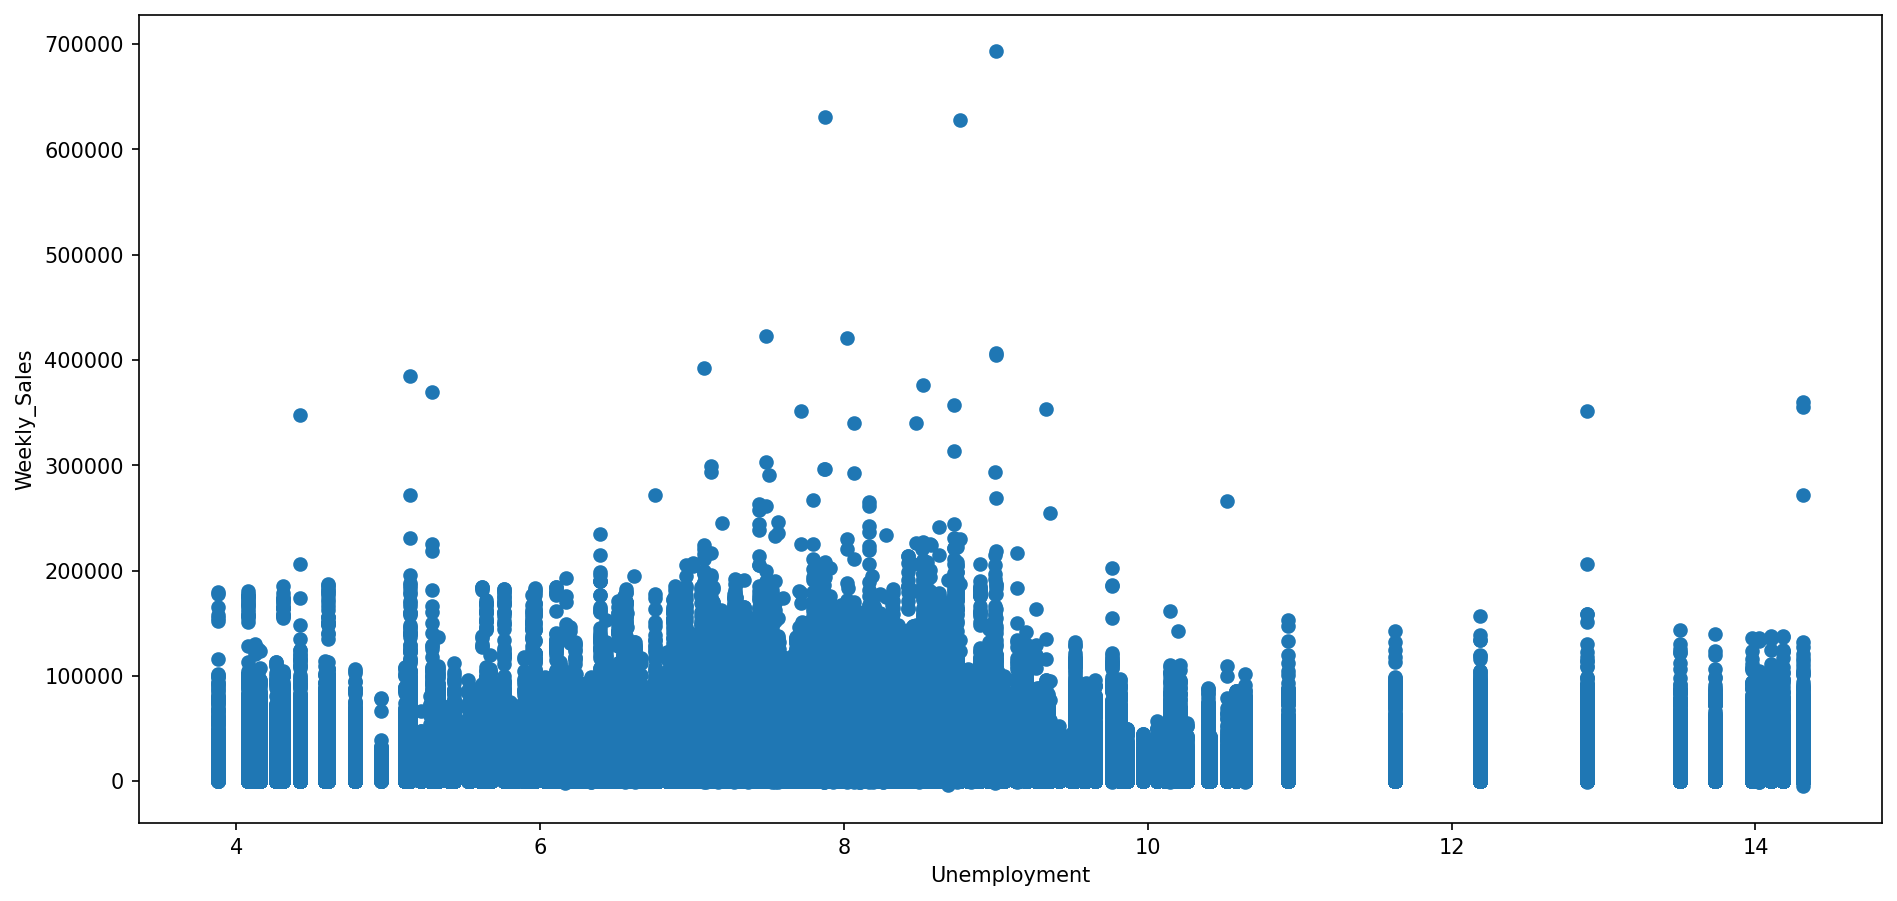

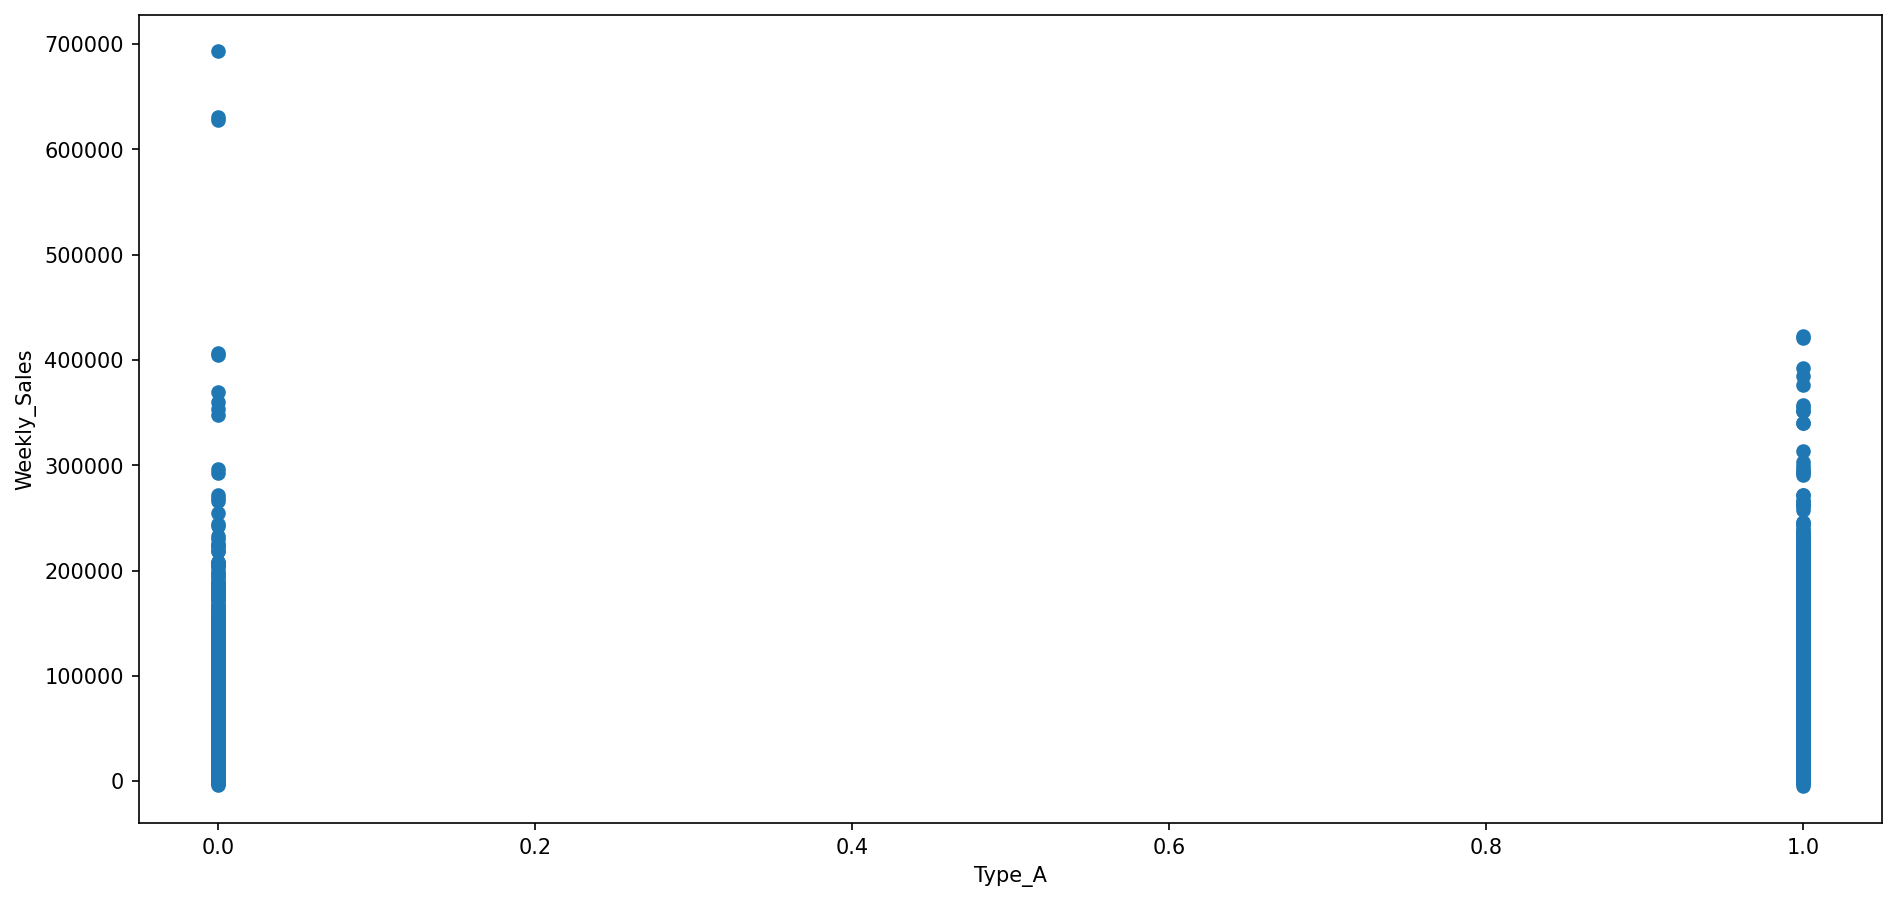

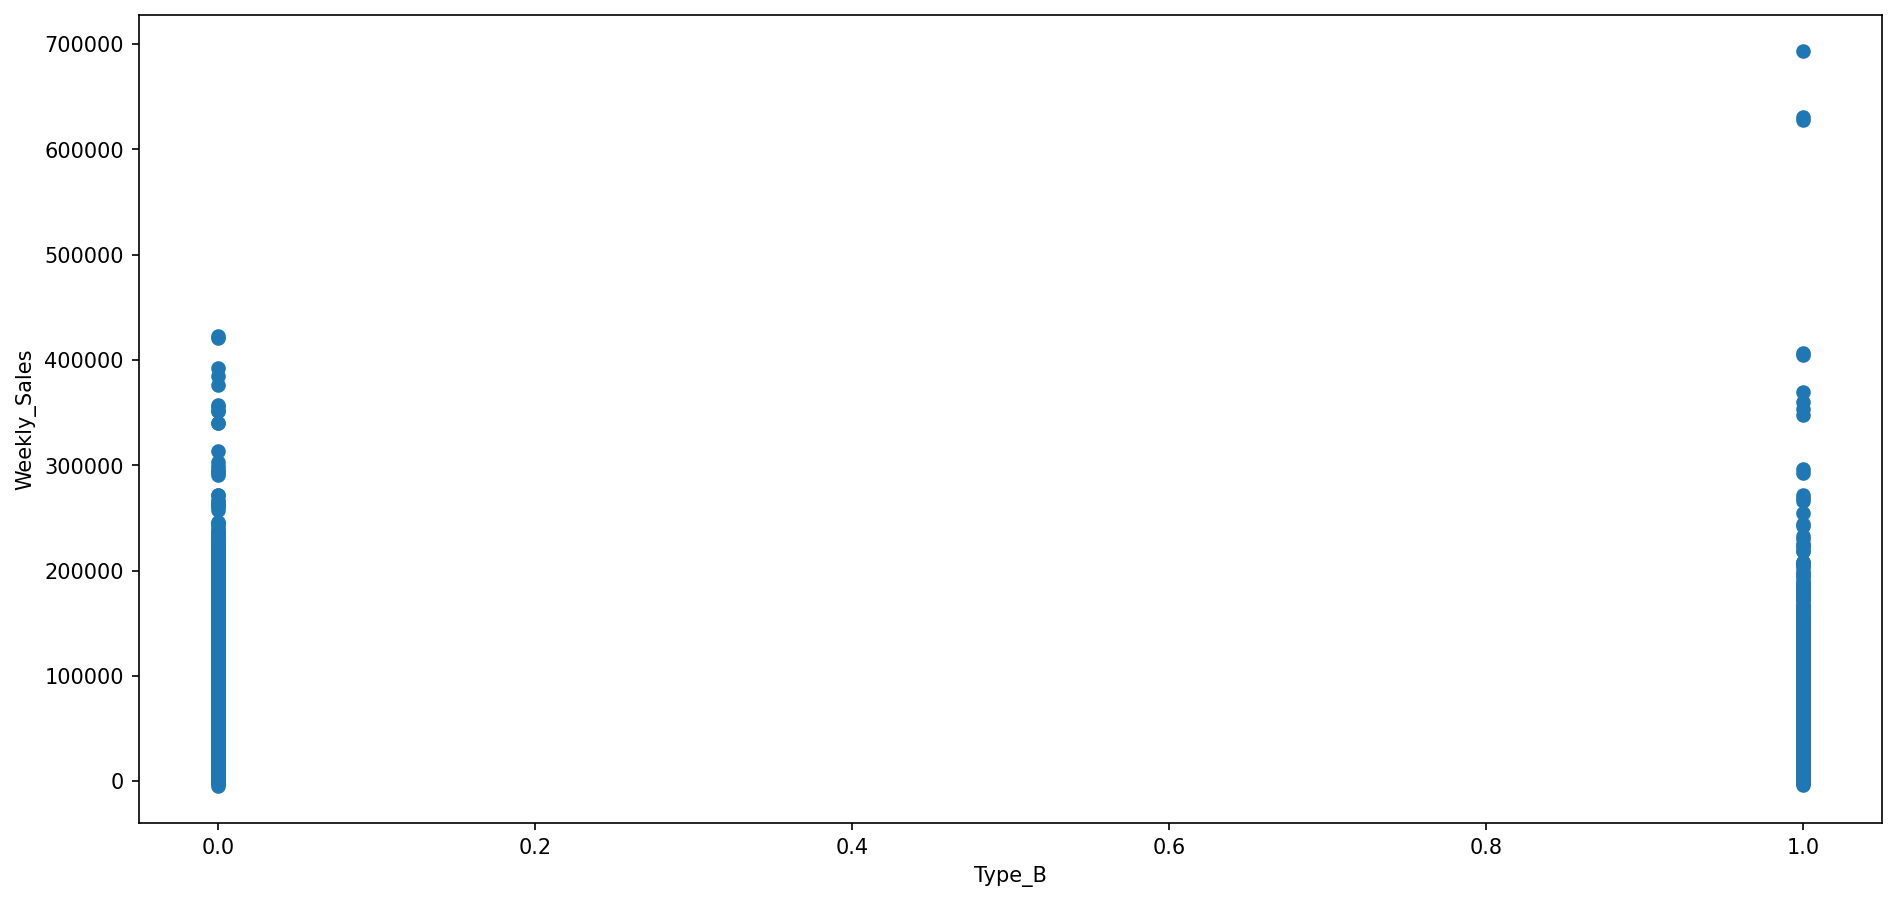

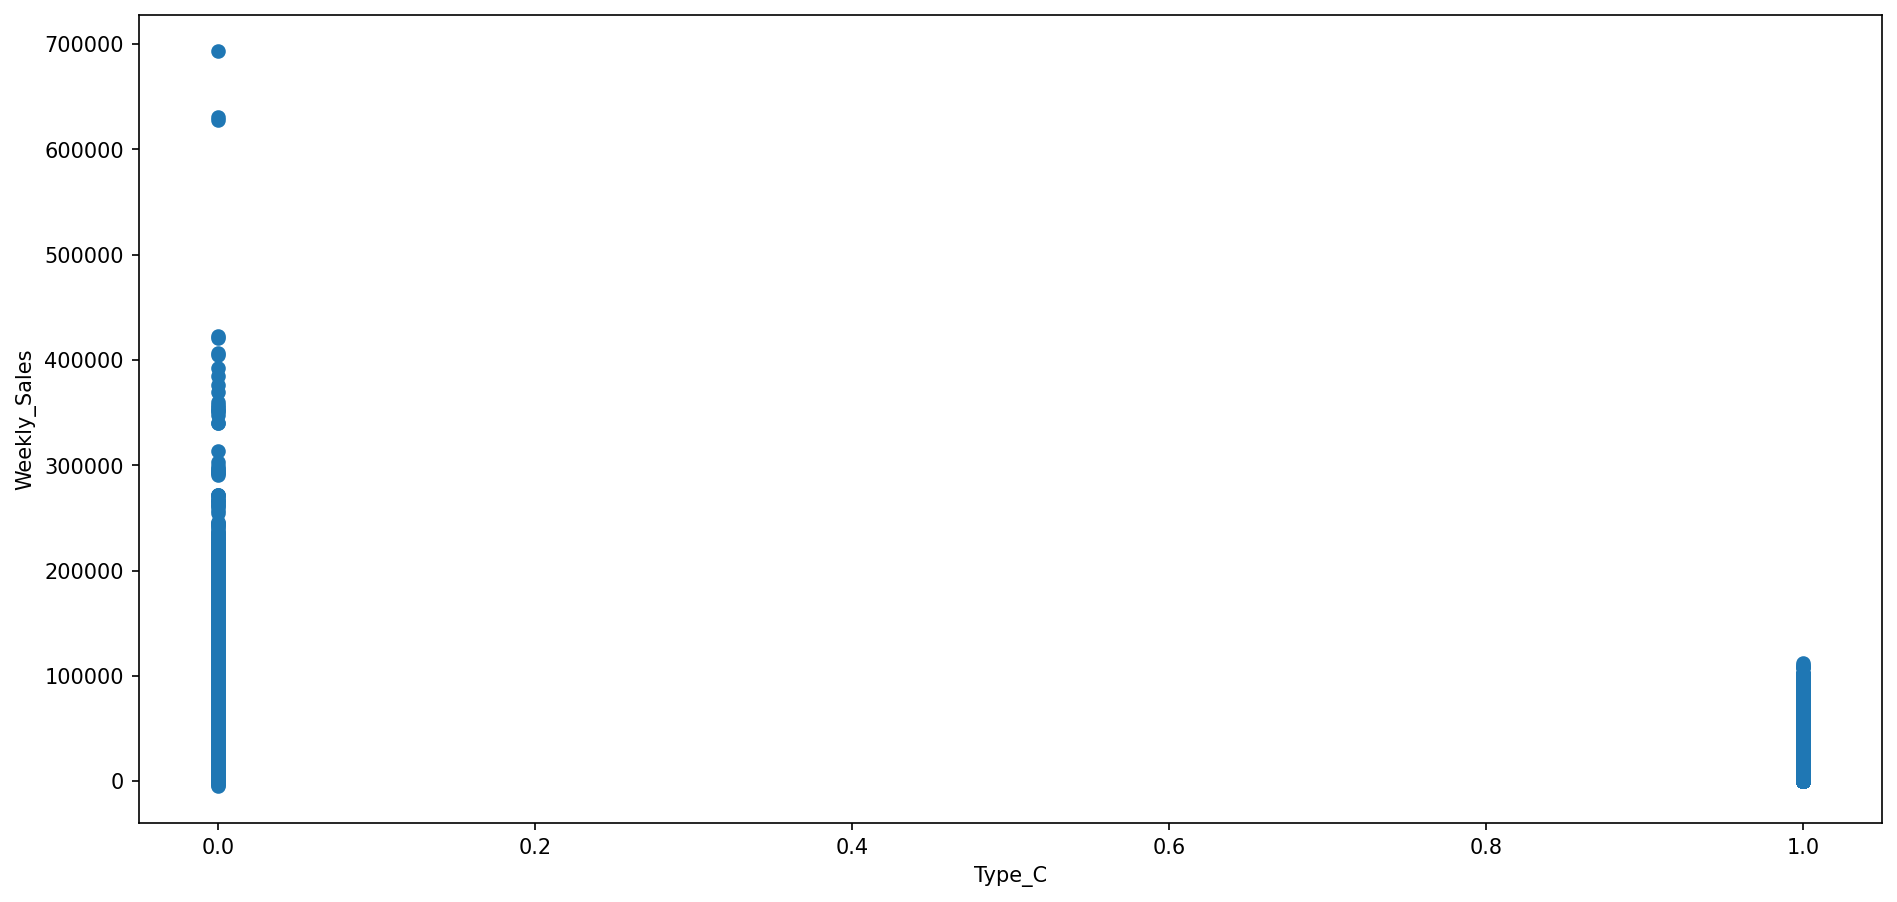

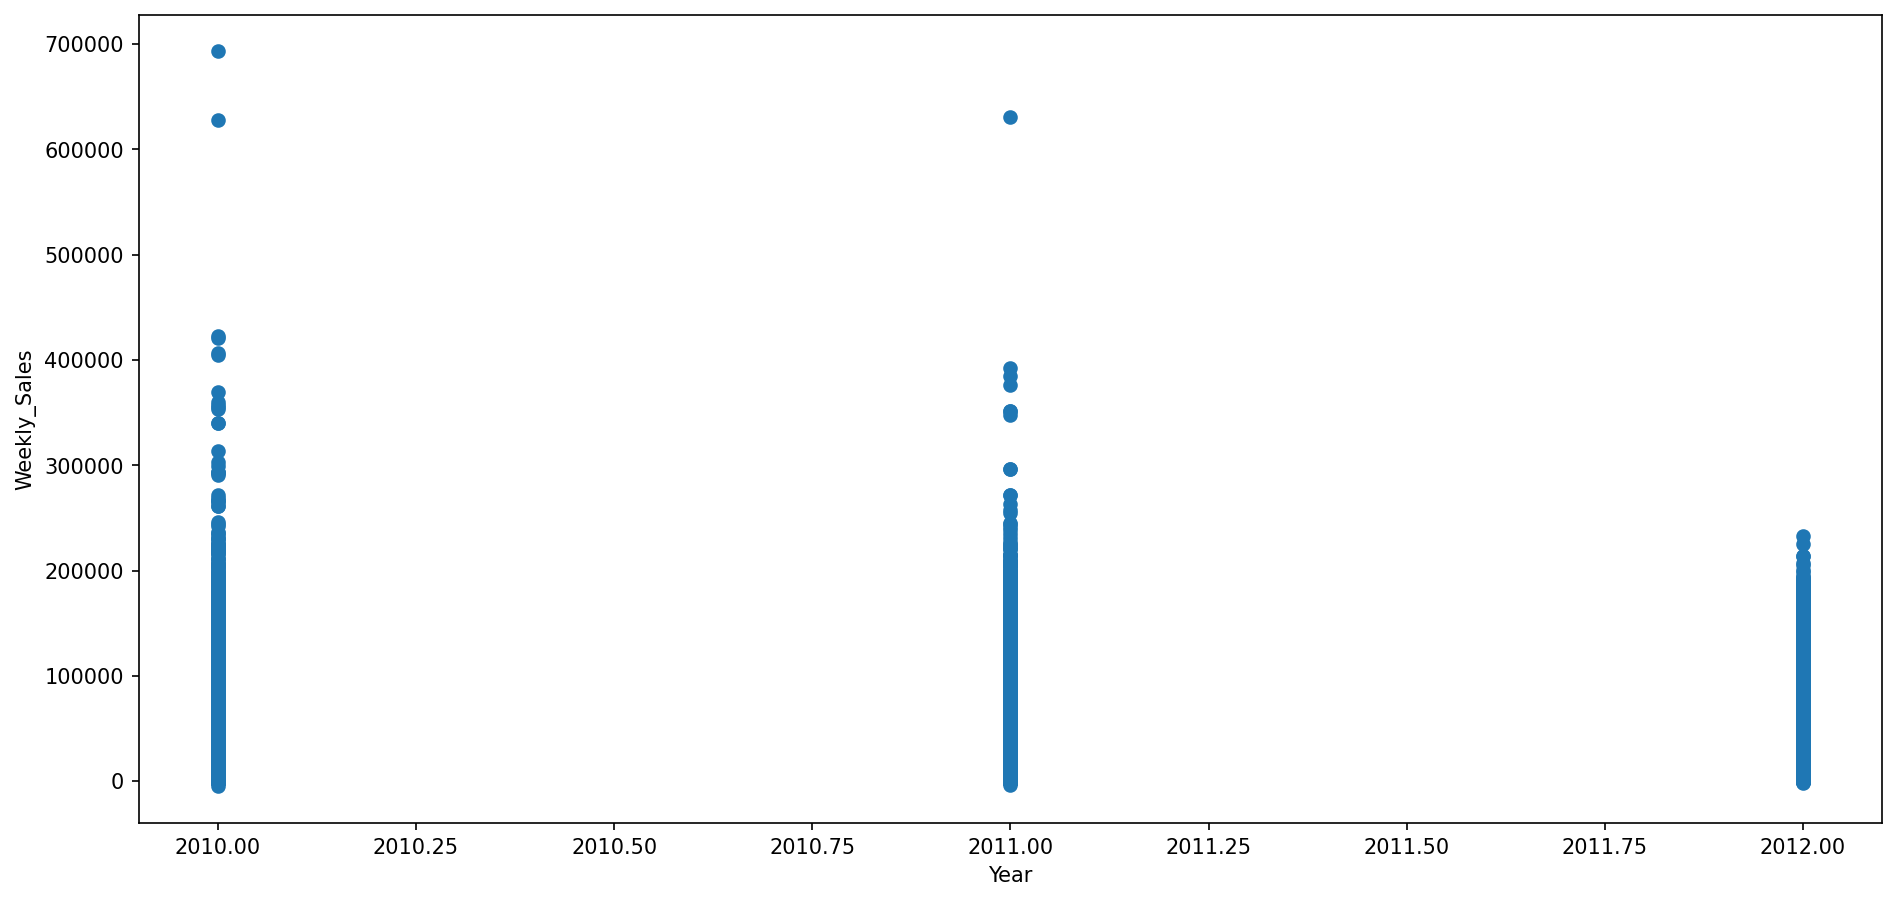

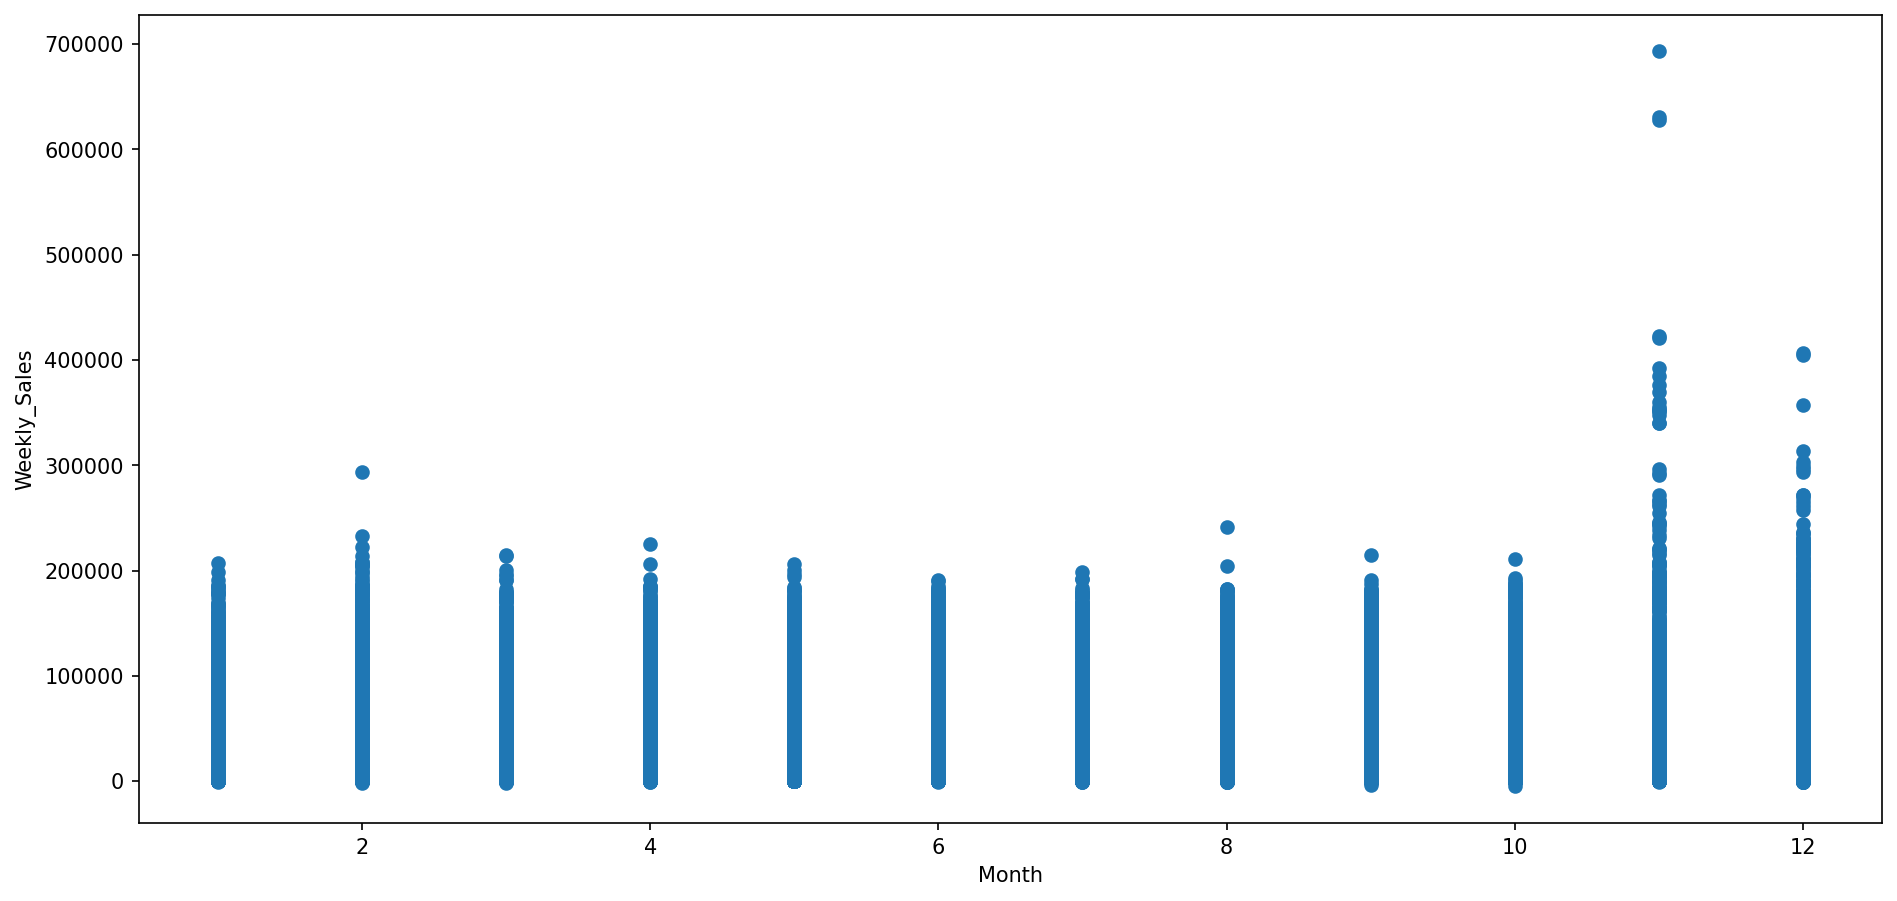

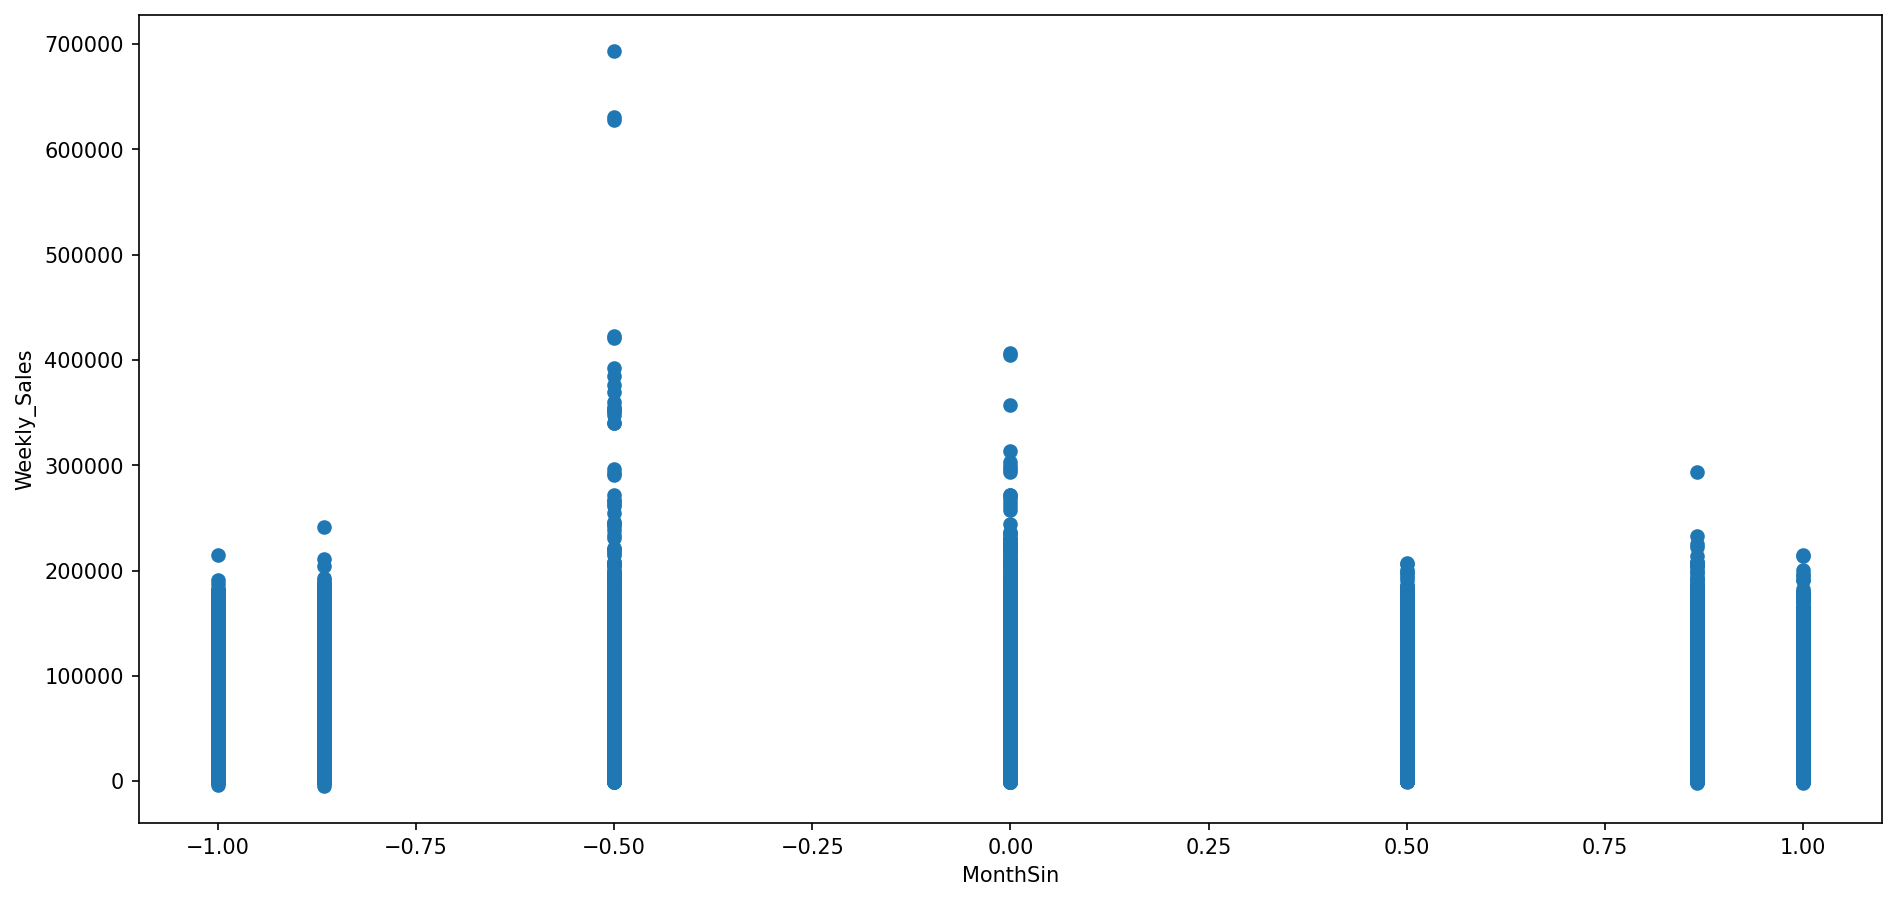

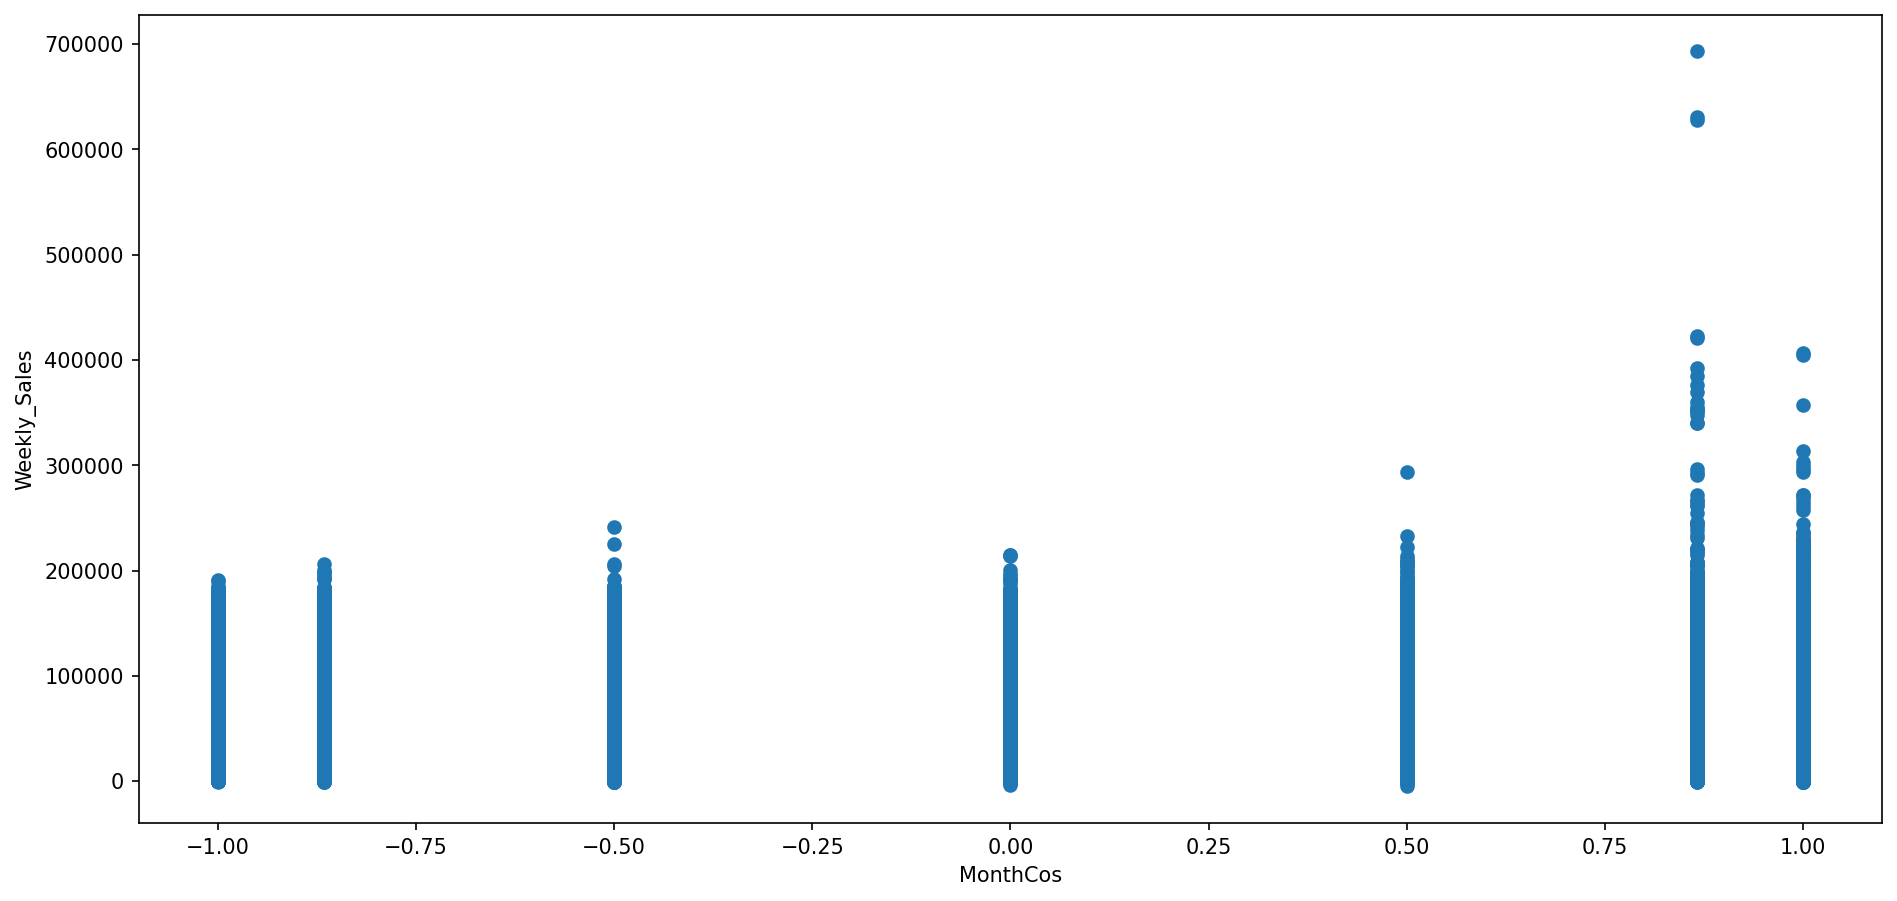

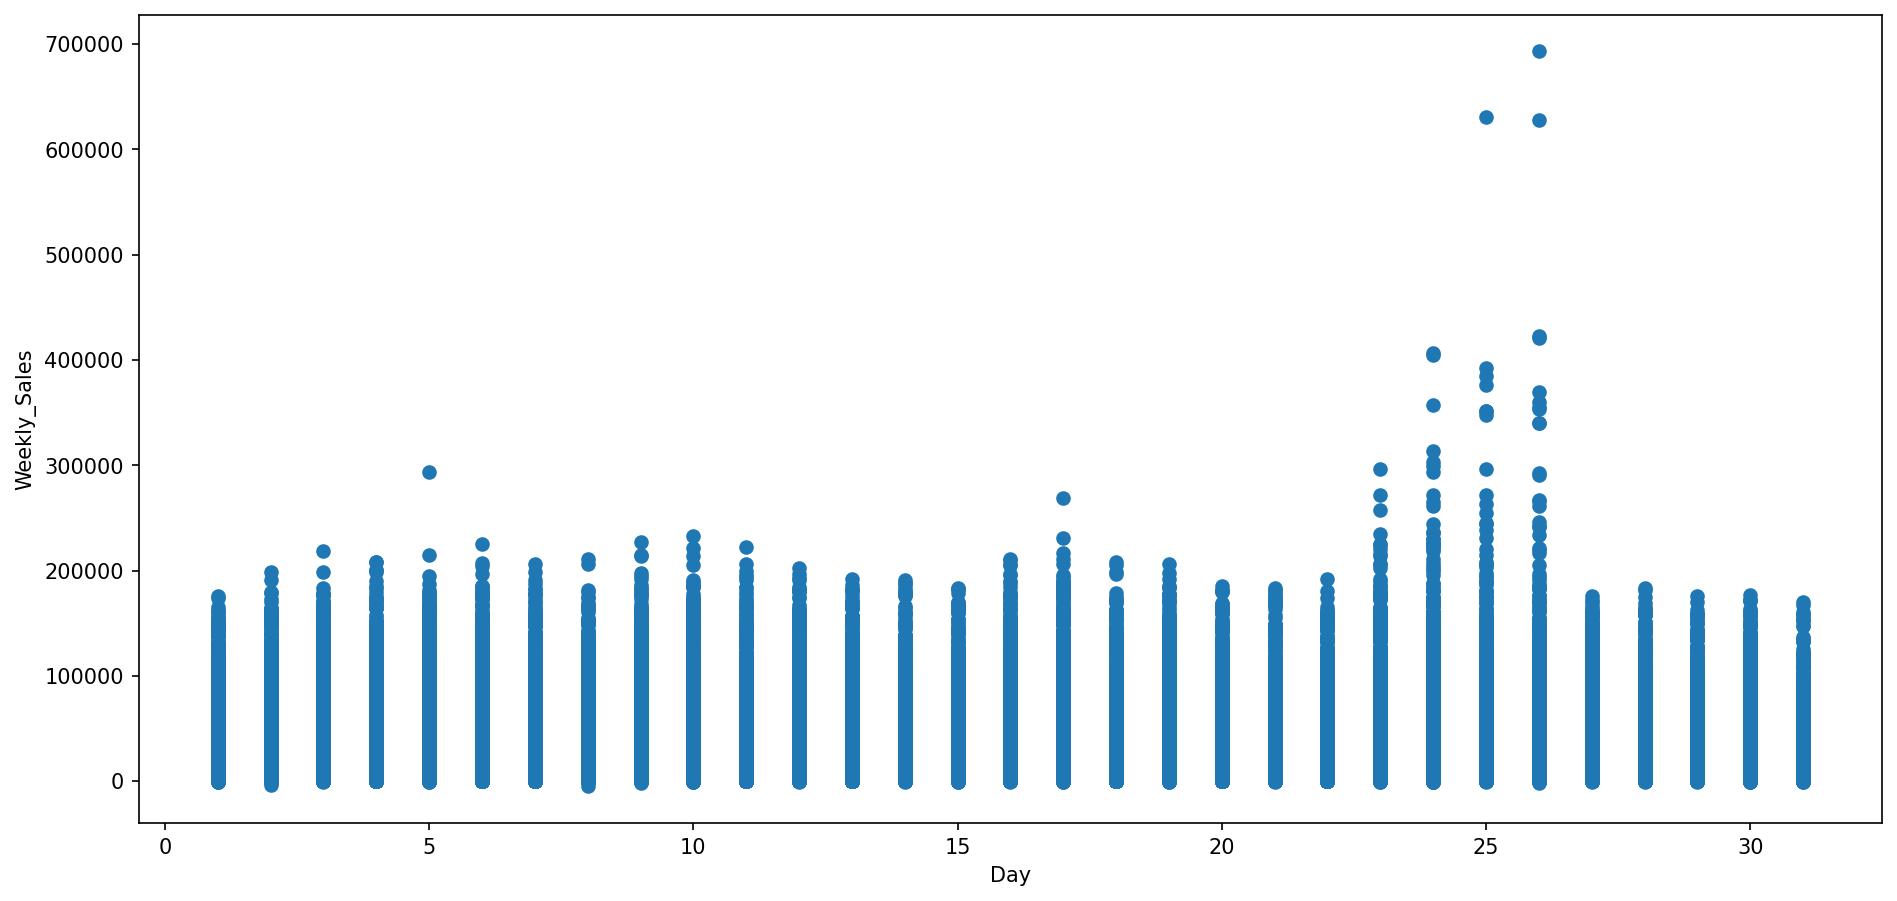

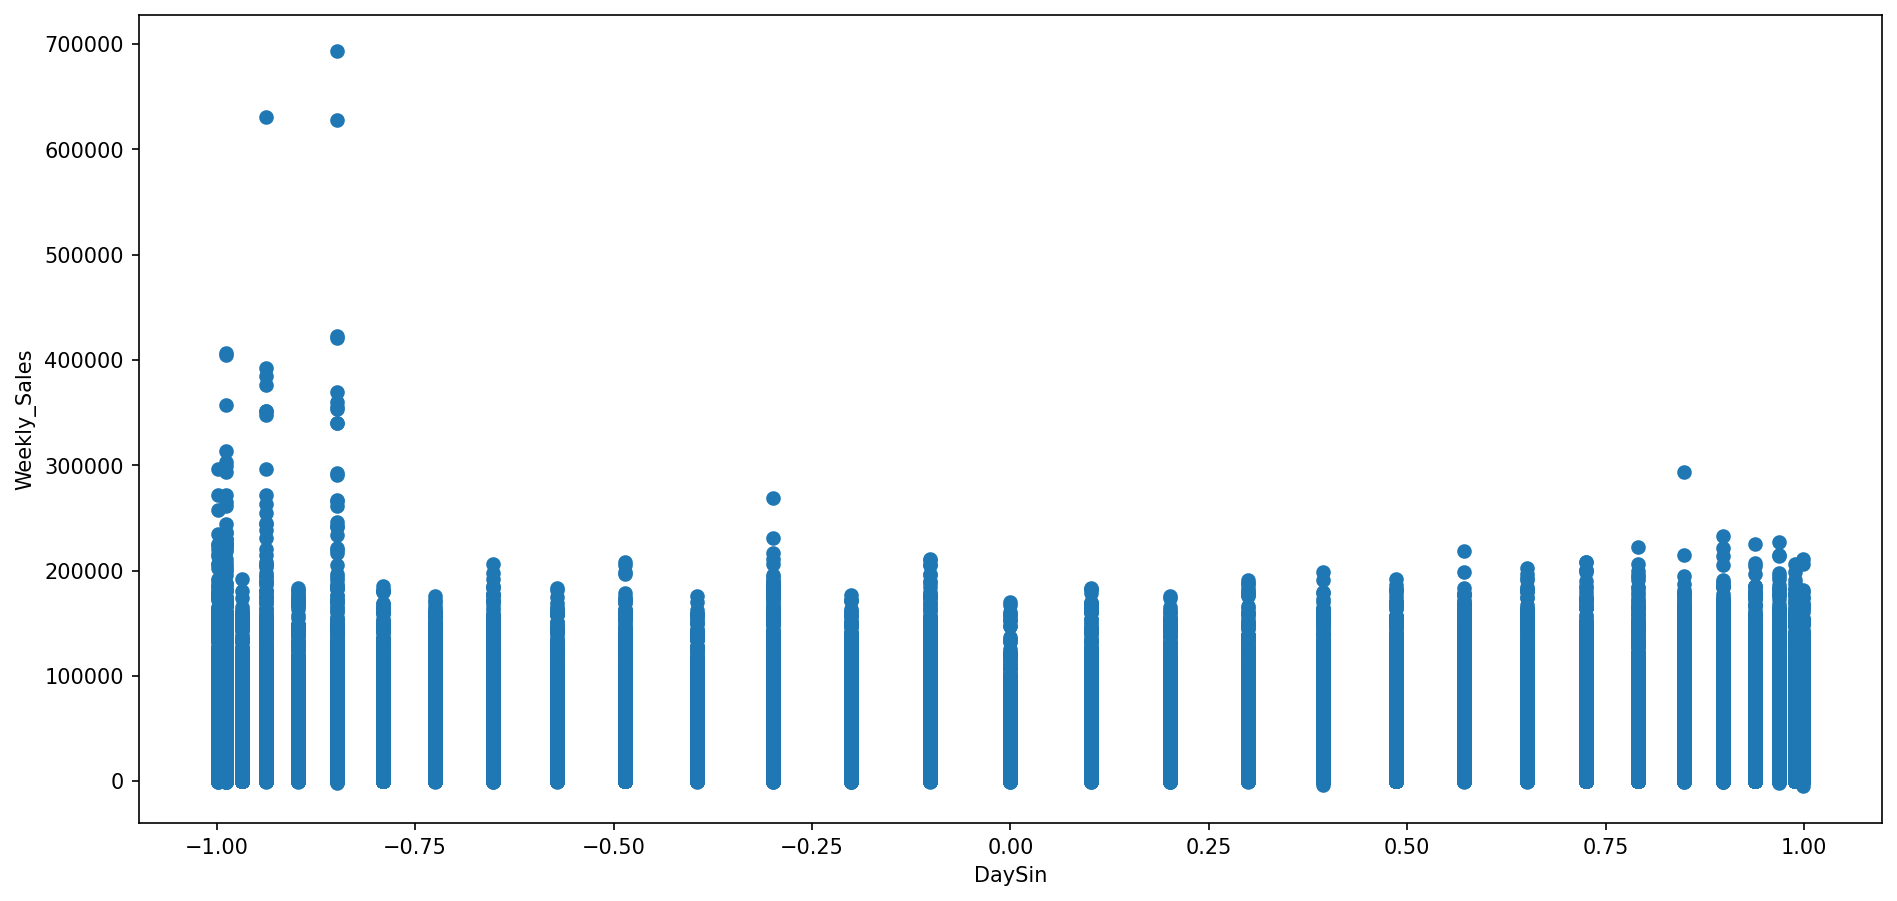

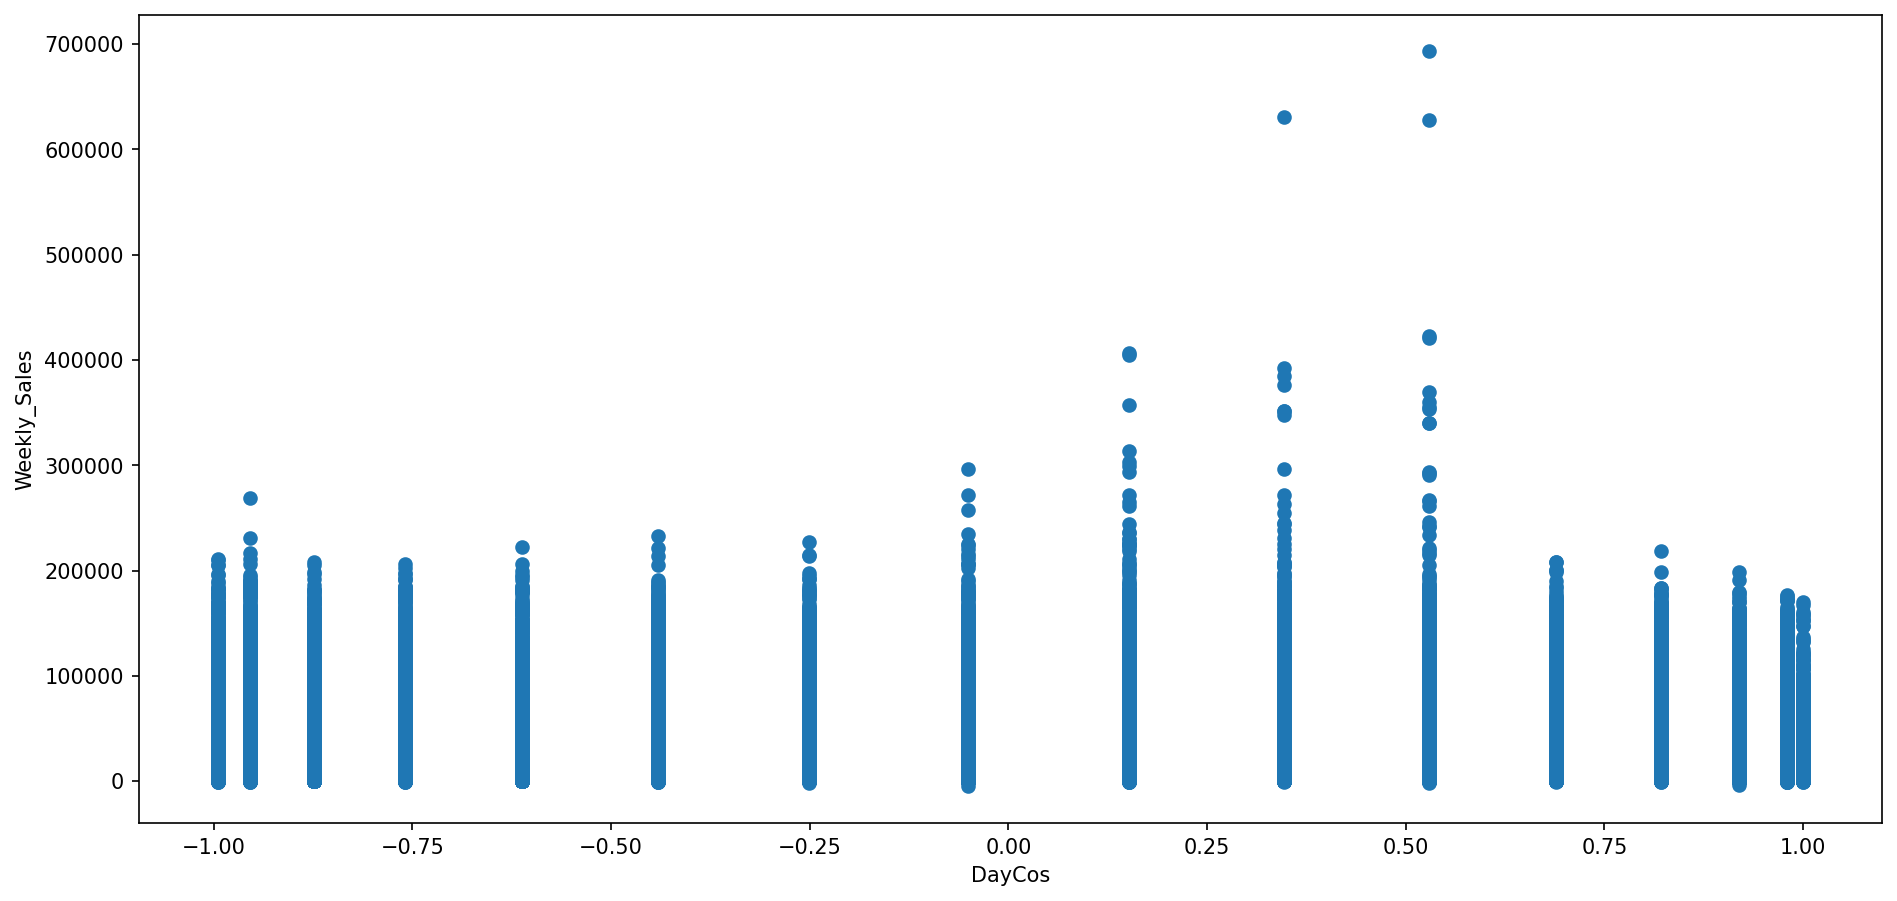

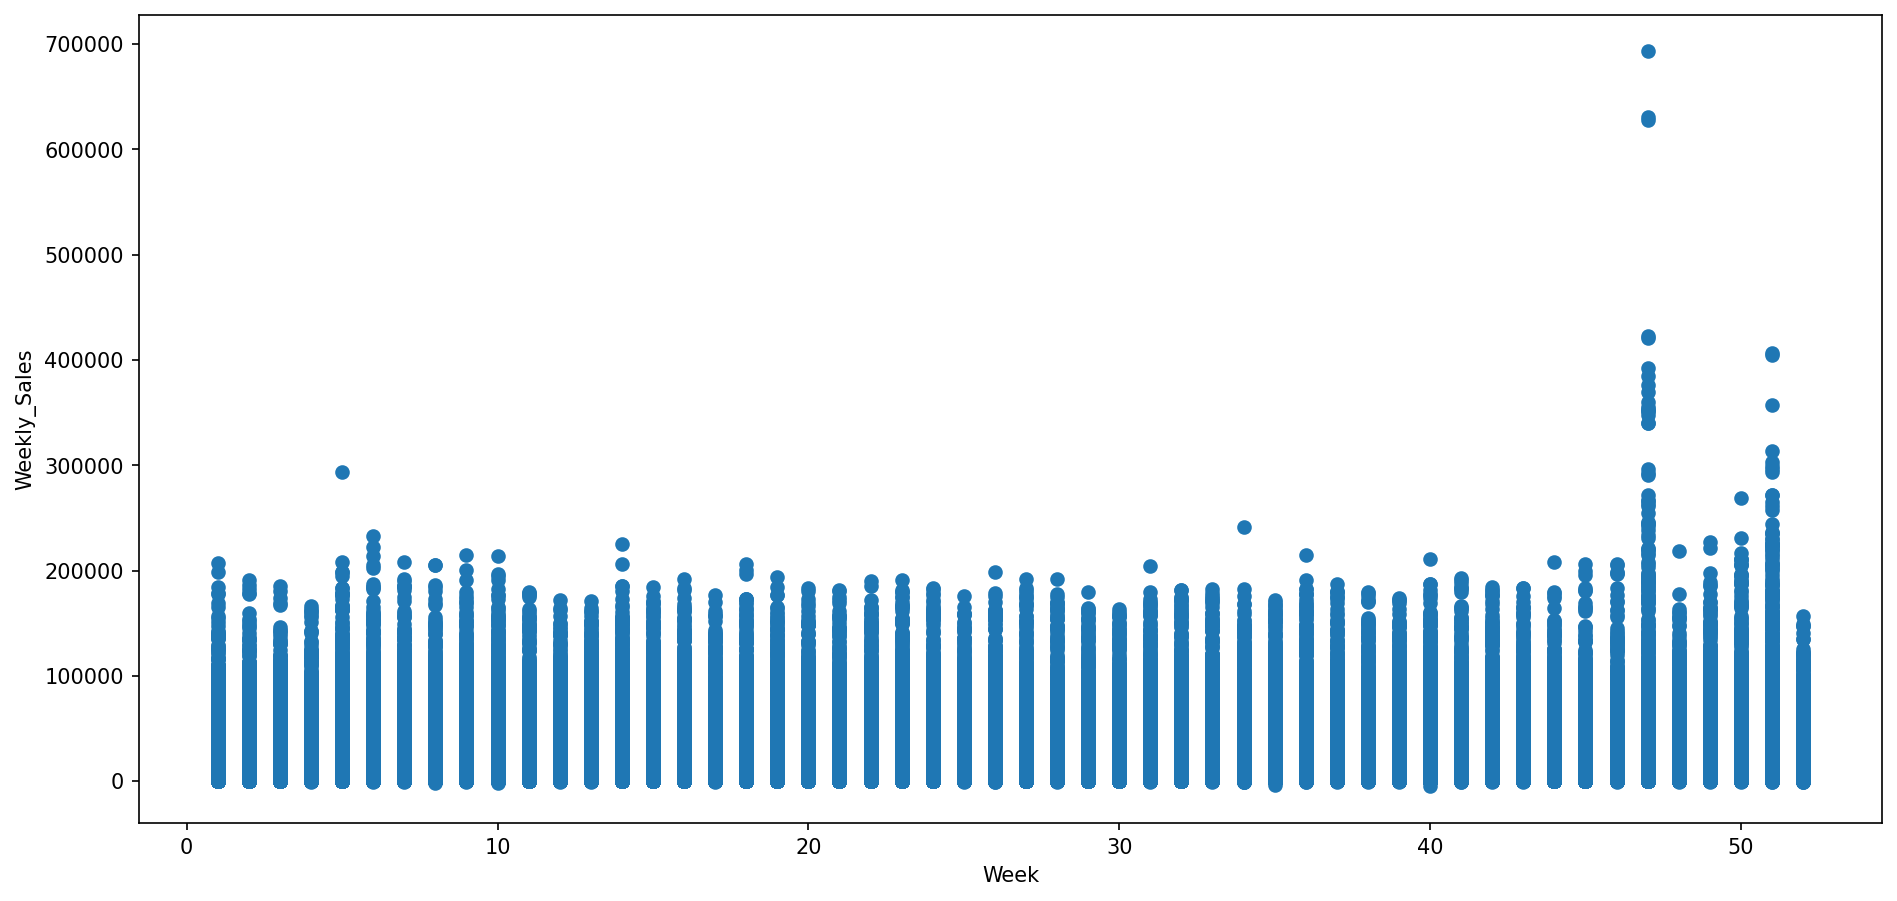

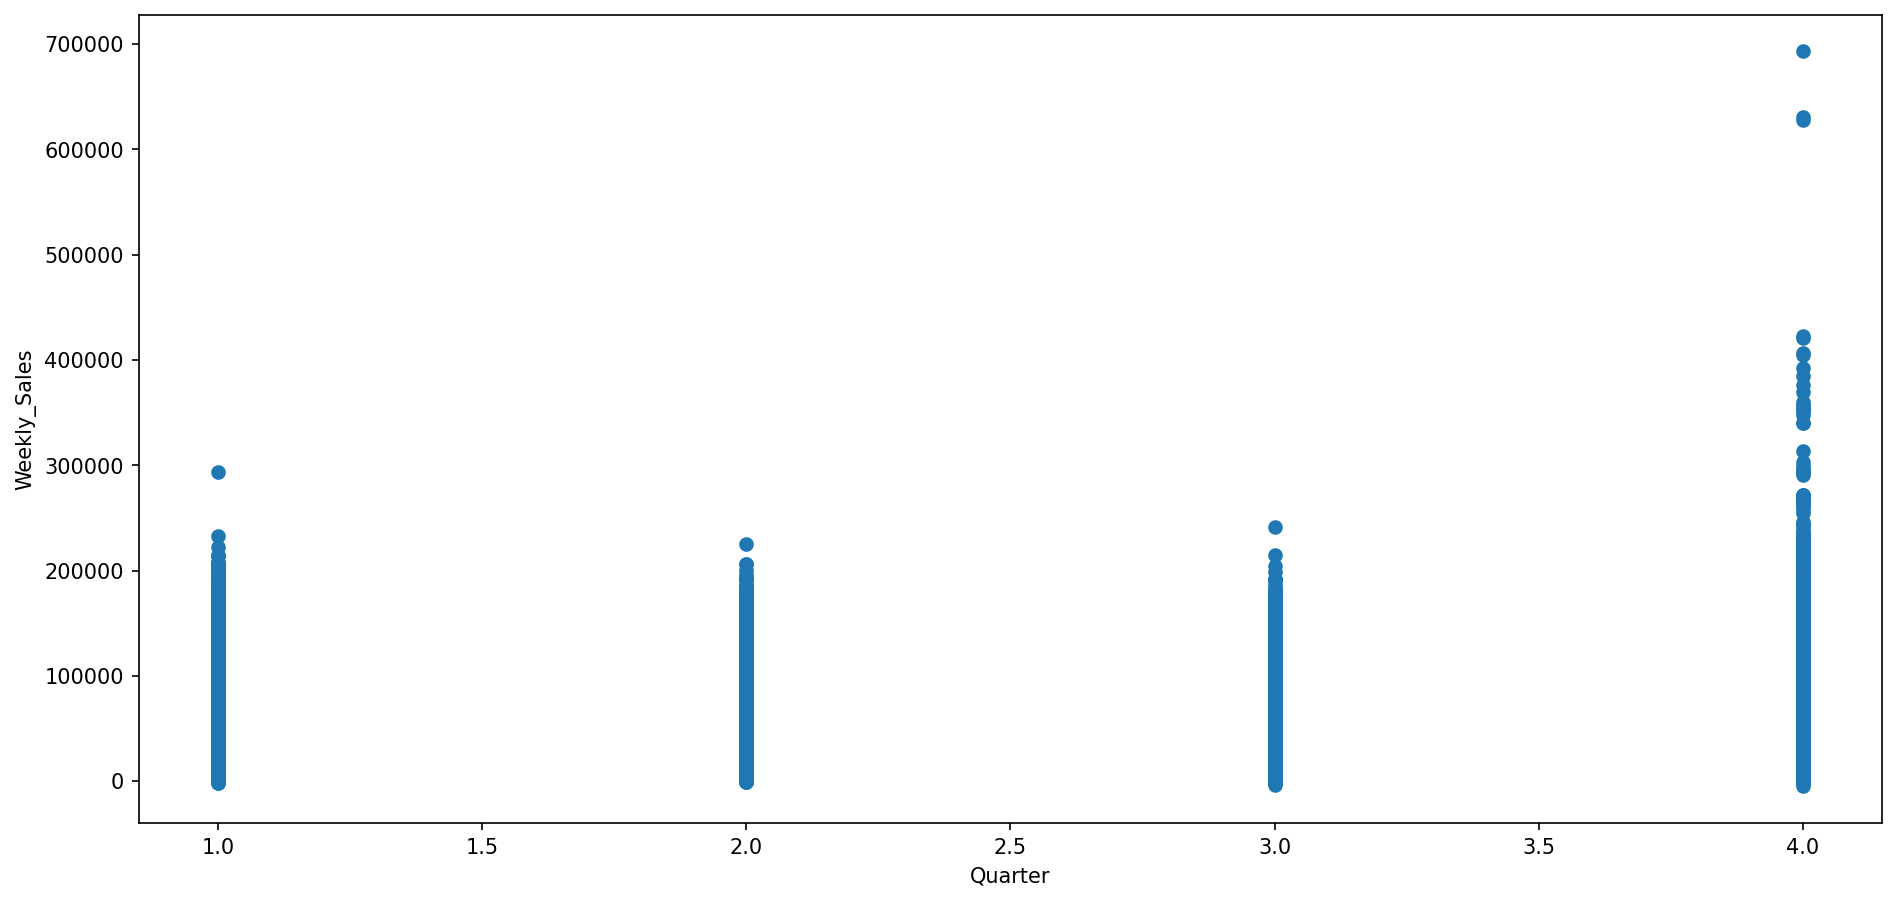

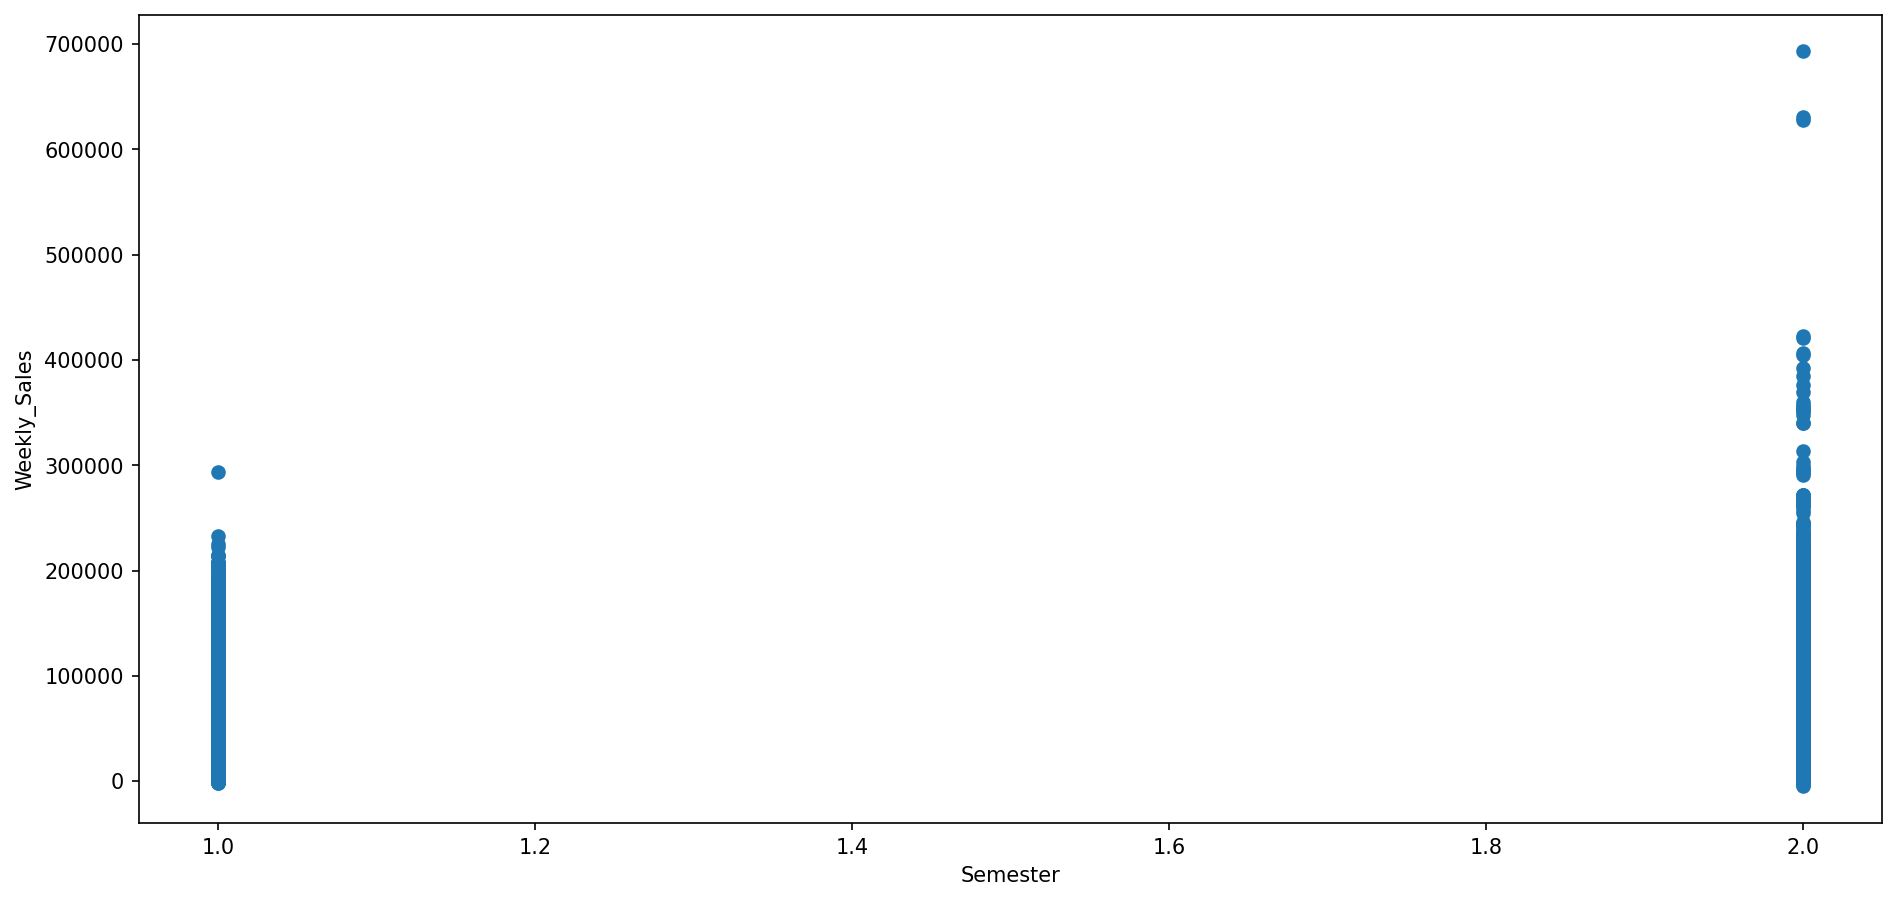

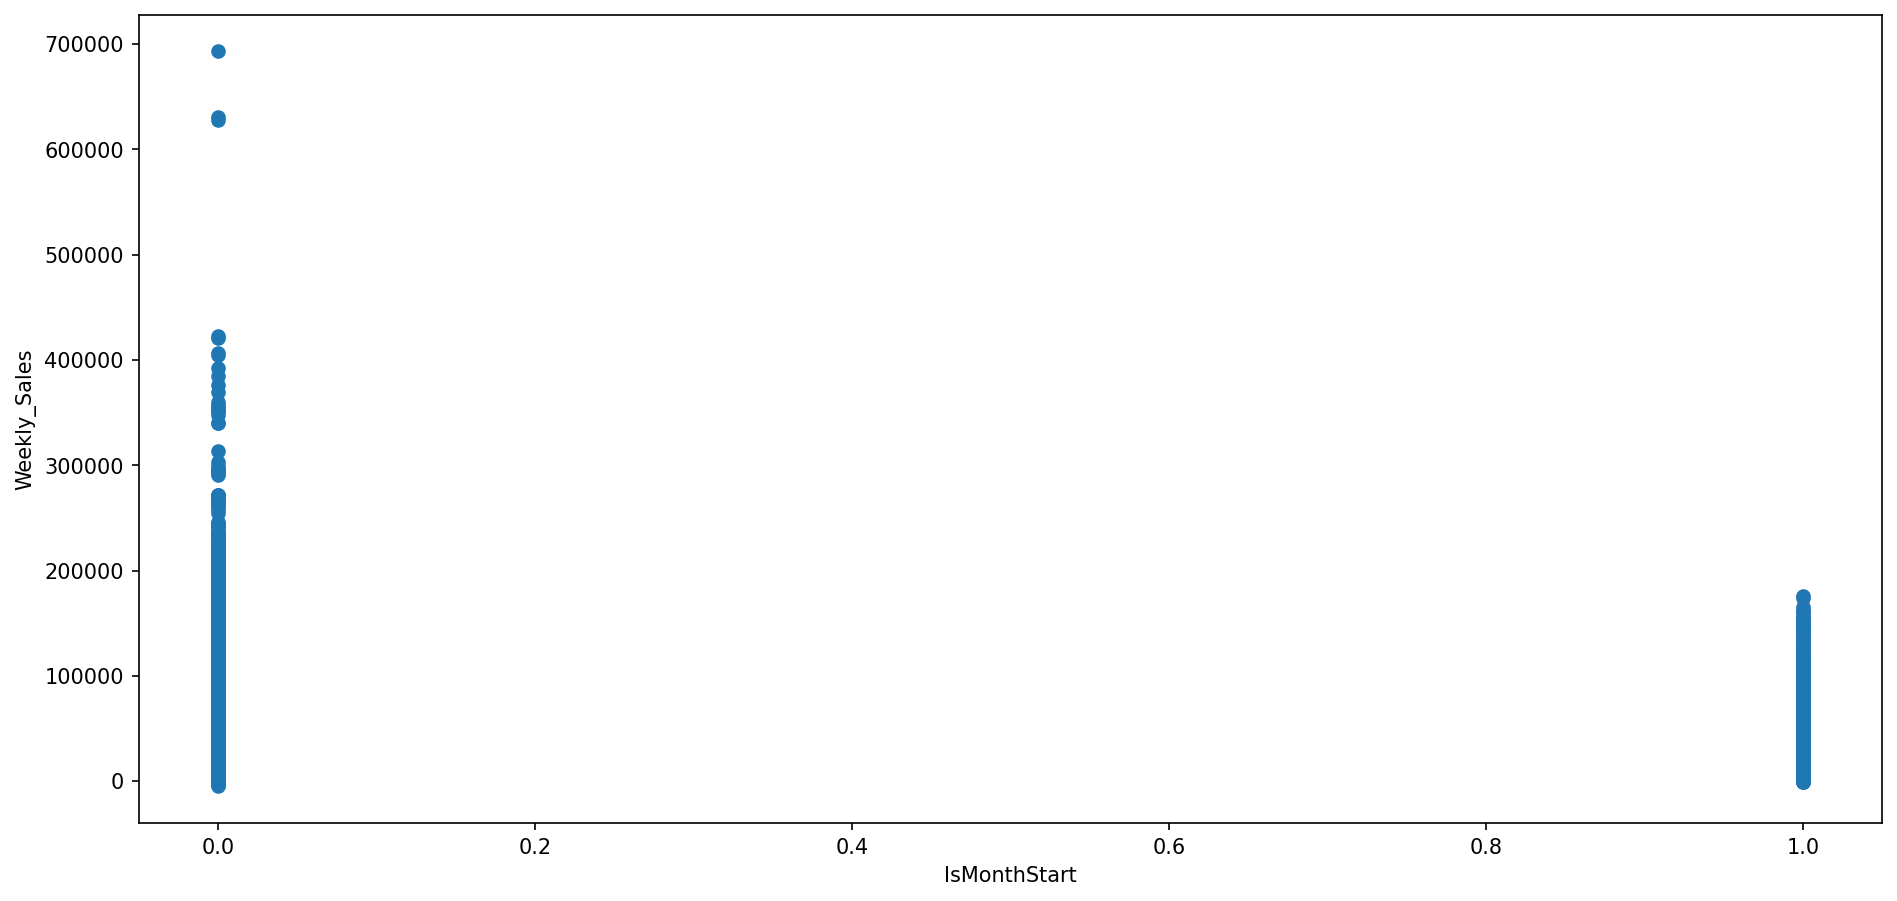

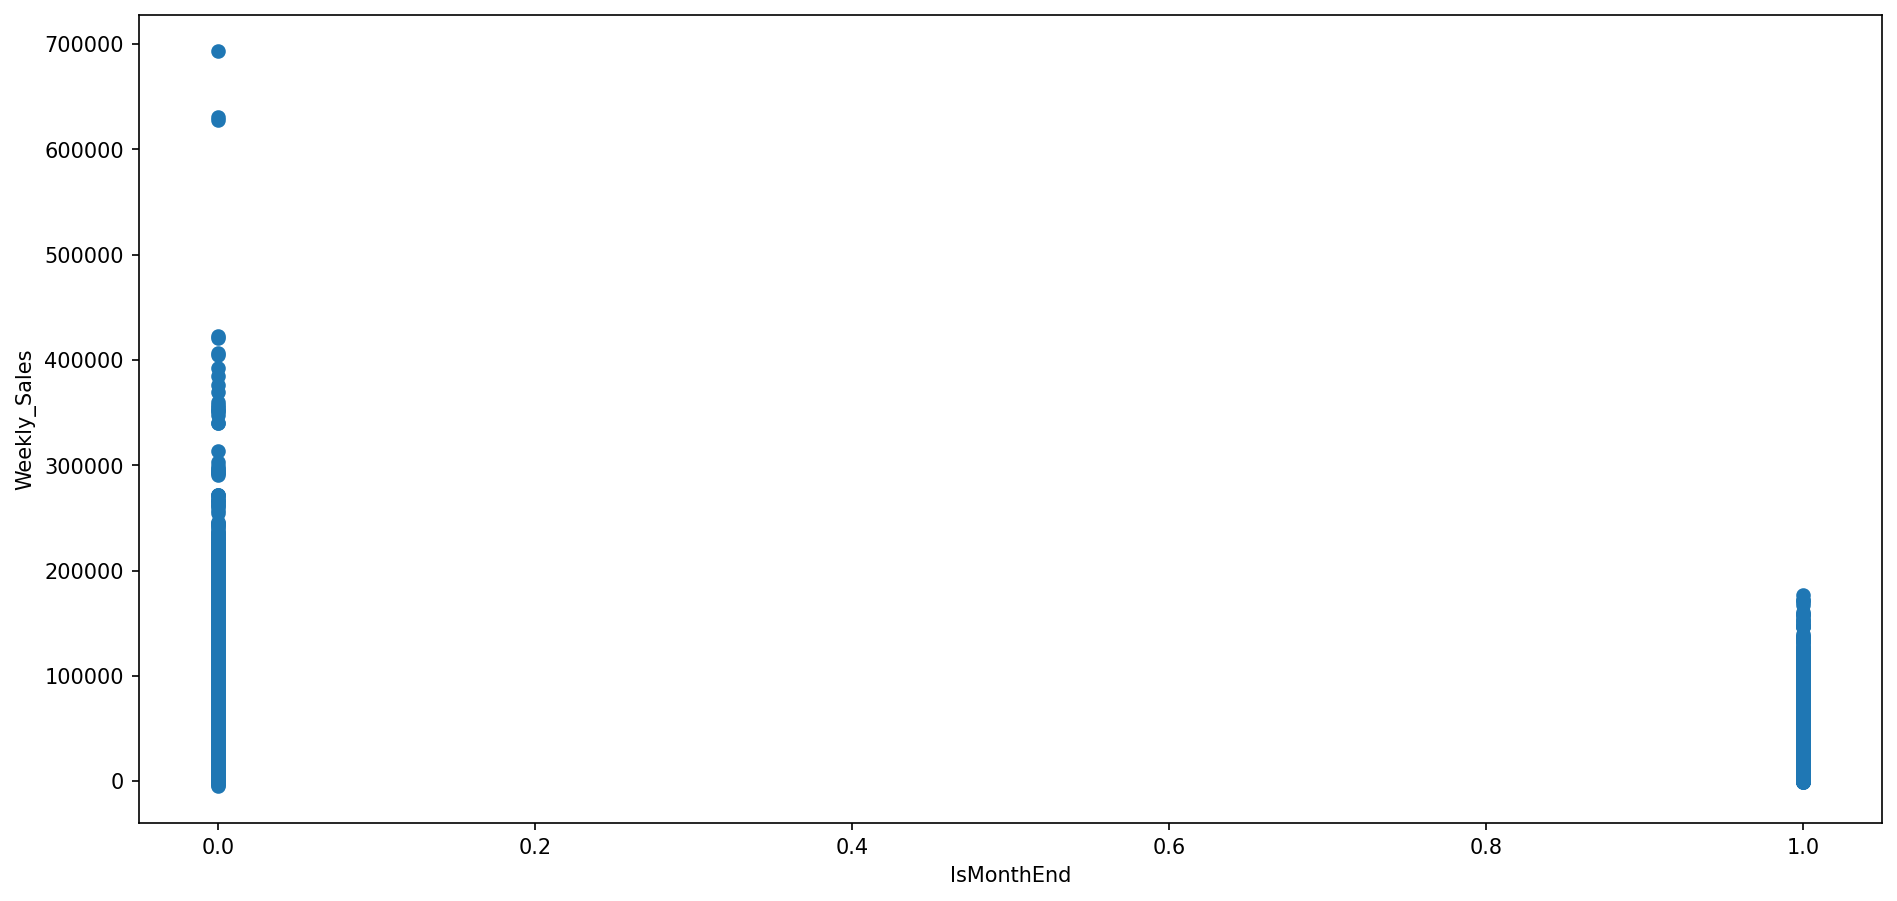

In [107]:
for col_name in X_training.columns:
    fig = plt.figure(figsize=(15,7), dpi=150)
    plt.scatter(X_training[col_name], y_training)
    plt.xlabel(col_name)
    plt.ylabel('Weekly_Sales')
    plt.show()

In [108]:
scaler = StandardScaler().fit(X_training) # Scaling data with respect to X_training
X_training_scaled = scaler.transform(X_training)
X_test_scaled = scaler.transform(X_test)

In [109]:
dt_reg = DecisionTreeRegressor()
dt_reg.fit(X_training_scaled, y_training)
dt_reg.score(X_test_scaled, y_test)

0.9637160203920553

In [110]:
xg_reg = XGBRegressor(learning_rate=0.45, max_depth=10, n_estimators=200)
xg_reg.fit(X_training_scaled, y_training)
xg_reg.score(X_test_scaled, y_test)

0.9821176211488751

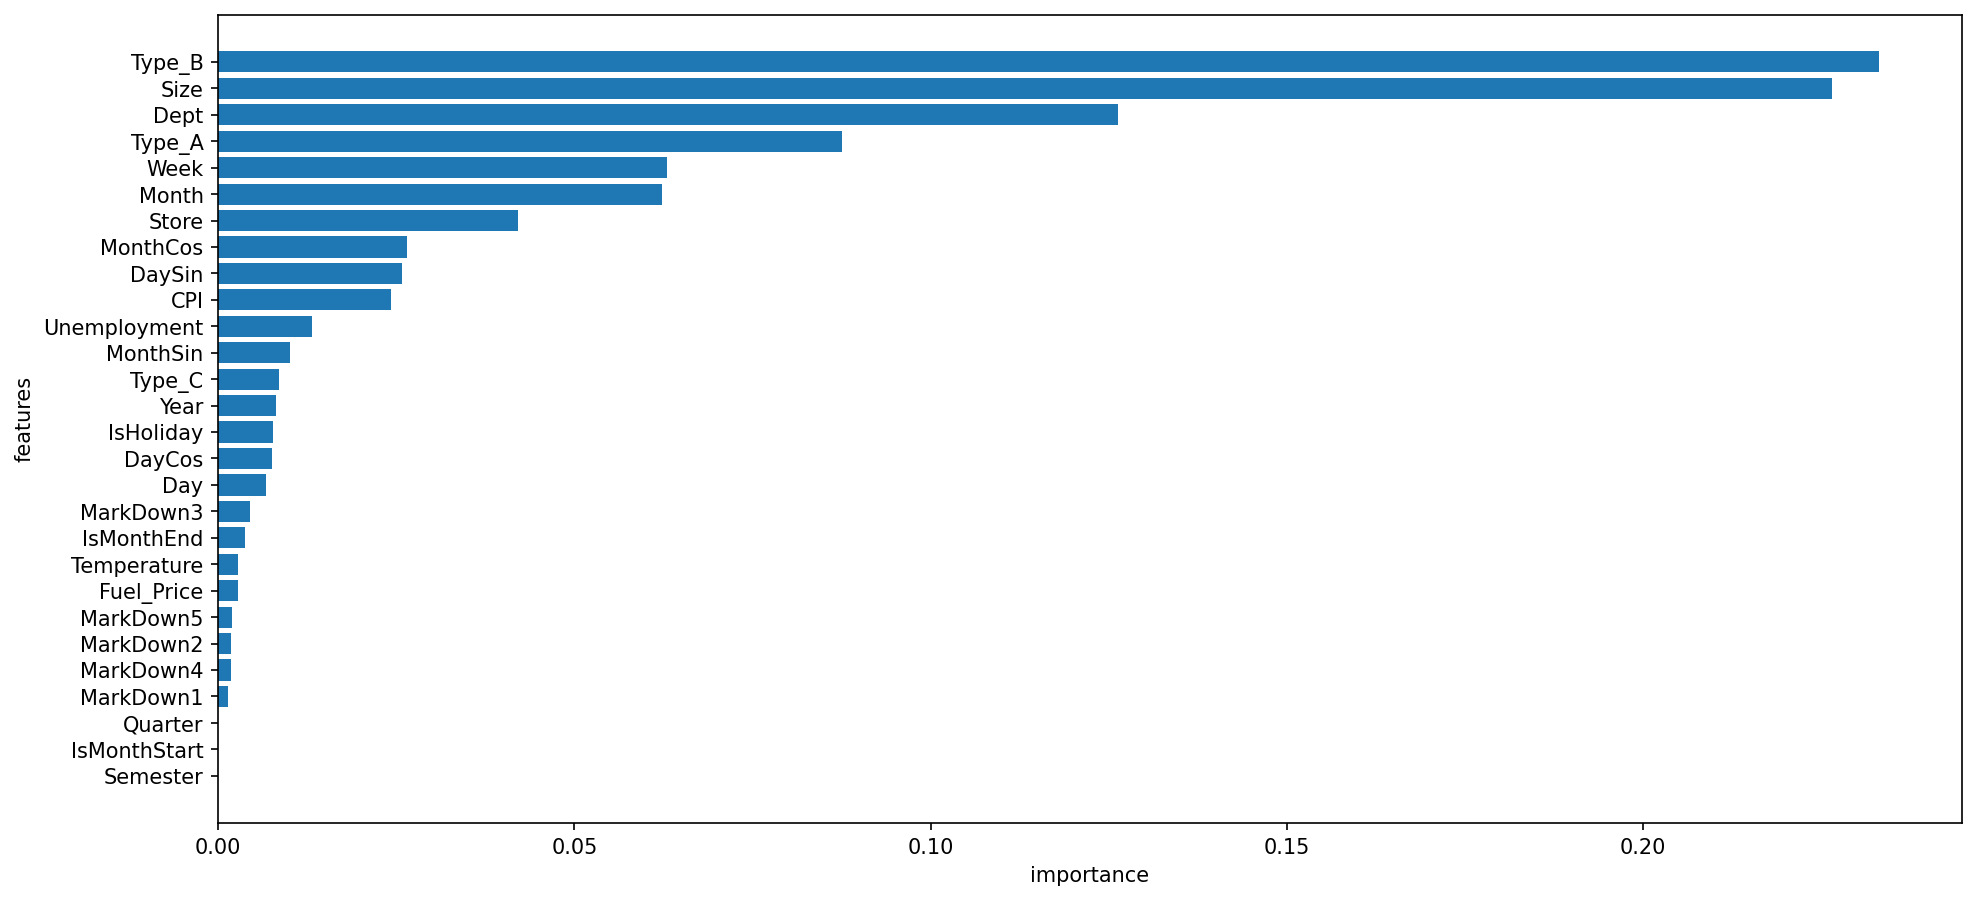

In [111]:
def plot_feature_importances(model):
      n_features = X.shape[1]
      idx = np.argsort(model.feature_importances_)
      plt.barh(range(n_features),model.feature_importances_[idx],align="center")
      plt.yticks(np.arange(n_features),X.columns[idx])
      plt.xlabel("importance")
      plt.ylabel("features")
      plt.show()
fig = plt.figure(figsize=(15, 7), dpi=150)
plot_feature_importances(xg_reg)

In [112]:
rf_reg = RandomForestRegressor()
rf_reg.fit(X_training_scaled, y_training)
rf_reg.score(X_test_scaled, y_test)

0.9794428109846621